# Supporting Information

# Correlation Analysis and Machine Learning Models for Predicting Deblocking Temperature

**Authors:** Remsha Rafiq, Ramakrishna Suresh, Barbaro Zulueta, Jessica Gondak, Hannah Zucco, Jason E. Shoemaker, John A. Keith, Goetz Veser

**Manuscript:** *Bond Energy Descriptors Enable Machine Learning with Limited Data: Design of Thermoplastic Polyurethane Recycling Agents*

**Year:** 2026 (*to be submitted to JACS*)

**Repository:** [github.com/BLZ11/deblocking_temp](https://github.com/BLZ11/deblocking_temp)

---

## Overview

This notebook accompanies the main manuscript and is organized into two parts:

**Part I — Correlation Analysis.** Exploratory analysis of linear relationships between quantum chemical descriptors and the deblocking temperature ($T_{\mathrm{deblock}}$), including a correlation heatmap and ranked bar plot.

**Part II — Machine Learning Models.** Evaluation of four regression algorithms (LASSO, Random Forest, Gaussian Process, Gradient Boosting) for predicting $T_{\mathrm{deblock}}$ from quantum chemical descriptors. Models are assessed via LOOCV ($n=19$), external test set ($n=2$), and compared across two feature sets (with and without BEBOP bond-energy descriptors).

**Performance metrics:** RMSE (°C), $R^2$, MAE (°C)

**Reproducibility:** Random seed 42; z-score normalization; all code and data in the repository.

---

## Table of Contents

### Part I: Correlation Analysis

| Section | Description |
|:--------|:------------|
| [1. Import Libraries](#part1-1) | Python dependencies |
| [2. Plot Configuration](#part1-2) | Matplotlib settings |
| [3. Load Data](#part1-3) | Import dataset |
| [4. Define Descriptors](#part1-4) | Feature set and labels |
| [5. Preprocessing and Correlation](#part1-5) | Z-score normalization and Pearson correlation |
| [6. Prepare Visualization Data](#part1-6) | Format bar plot and heatmap inputs |
| [7. Combined Figure](#part1-7) | Two-panel correlation figure |
| [8. Summary Statistics](#part1-8) | Correlation ranking |

### Part II: Machine Learning Models

| Section | Description |
|:--------|:------------|
| [9. Setup and Configuration](#part2-1) | Libraries, feature sets, hyperparameters |
| [10. Data Loading and Preprocessing](#part2-2) | Train/test split and feature scaling |
| [11. LASSO Regression](#part2-3) | L1-regularized linear model |
| [12. Random Forest Regression](#part2-4) | Bagged decision-tree ensemble |
| [13. Gaussian Process Regression](#part2-5) | Bayesian regression with ARD kernel |
| [14. Gradient Boosting Regression](#part2-6) | Sequential boosted ensemble |
| [15. Model Comparison — LOOCV](#part2-7) | Performance table and parity plots |
| [16. BEBOP vs Non-BEBOP Comparison](#part2-8) | Impact of bond-energy descriptors |
| [17. Model Complexity — AIC/BIC](#part2-9) | Information-theoretic overfitting assessment |
| [18. External Test Set Predictions](#part2-10) | Held-out compound validation |
| [19. Residual Analysis](#part2-11) | Residual plots for all 21 systems |
| [20. Paired *t*-Tests](#part2-12) | Statistical comparison of models |
| [21. Bootstrap Confidence Intervals](#part2-13) | 95% CI on pairwise ΔRMSE |

---

---

# Part I: Correlation Analysis

Exploratory analysis of linear relationships between quantum chemical descriptors and $T_{\mathrm{deblock}}$ using the Pearson correlation coefficient:

$$r_{xy} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

Interpretation: $|r| \geq 0.7$ strong, $0.4 \leq |r| < 0.7$ moderate, $|r| < 0.4$ weak. All features are z-score normalized before computing correlations.

---

## 1. Import Libraries <a id="part1-1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 2. Plot Configuration <a id="part1-2"></a>

Set global matplotlib parameters for publication-quality figures.

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0

## 3. Load Data <a id="part1-3"></a>

Import the dataset containing quantum chemical descriptors and experimental deblocking temperatures for $n = 21$ compounds (19 training, 2 held-out test).

In [3]:
# Load dataset from Excel file
file_path = 'Paper 2 Data Oct 14th.xlsx'  # Update this path to your data file location
df = pd.read_excel(file_path)
df = df.dropna(subset=['Tdeblock'])

# Display dataset information
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {len(df)}")

Dataset shape: (21, 74)
Number of samples: 21


## 4. Define Descriptors and Labels <a id="part1-4"></a>

Selected descriptors (9 features + target):

| Category | Descriptor | Symbol | Physical Interpretation |
|:---------|:-----------|:-------|:-----------------------|
| Thermodynamic | Enthalpy change | $\Delta H$ | Reaction energetics of capping |
| Electronic | Nucleophilicity | $N$ | Electron-donating ability |
| Electronic | Resonance energy (cap) | $E_{\mathrm{res,cap}}$ | Electronic stabilization in capped state |
| Structural | Gross bond energy 1 | $E_1^{\mathrm{Gross}}$ | Total energy of primary bond (BEBOP) |
| Structural | Gross bond energy 2 | $E_2^{\mathrm{Gross}}$ | Total energy of secondary bond (BEBOP) |
| Electronic | Hybridization energy | $E_{1,\mathrm{N/O,cap}}^{\mathrm{hyb}}$ | Energy penalty from orbital mixing (BEBOP) |
| Electronic | HOMO-LUMO gap (cap) | $\Delta E_{\mathrm{H-L,cap}}$ | Kinetic stability / reactivity indicator |
| Geometric | Radius of gyration | $R_G$ | Molecular size / shape descriptor |
| Geometric | Molar volume | $V$ | Steric bulk measure |
| Target | Deblocking temperature | $T_{\mathrm{deblock}}$ | Experimental observable (°C) |

In [4]:
# Define features for correlation analysis
columns_to_normalize = [
    'delH (Jmol)',                          # Enthalpy change
    'N (Jmol)',                             # Nucleophilicity
    'Resonance cap (Jmol)',                 # Resonance energy (cap)
    'Gross bond 1 (Jmol)',                  # Gross bond energy 1
    'Gross bond 2 (Jmol)',                  # Gross bond energy 2
    'N/O - H hyb (cap) (Jmol)',             # Hybridization energy (cap)
    'homo lumo energy gap cap (Jmol)',      # HOMO-LUMO gap (cap)
    'Radius of Gyration (m)',               # Molecular size descriptor
    'Molar Volume (m3/mol)',                # Molecular volume
    'Tdeblock'                              # Target variable
]

# Create labels with LaTeX formatting
pretty_names = {
    'delH (Jmol)': r'$\Delta H$',
    'N (Jmol)': r'$N$',
    'Resonance cap (Jmol)': r'$E_{\mathrm{res,cap}}$',
    'Gross bond 1 (Jmol)': r'$E_{1}^{\mathrm{Gross}}$',
    'Gross bond 2 (Jmol)': r'$E_{2}^{\mathrm{Gross}}$',
    'N/O - H hyb (cap) (Jmol)': r'$E_{1,\mathrm{N/O,cap}}^{\mathrm{hyb}}$',
    'homo lumo energy gap cap (Jmol)': r'$\Delta E_{\mathrm{H-L,cap}}$',
    'Radius of Gyration (m)': r'$R_{G}$',
    'Molar Volume (m3/mol)': r'$V$',
    'Tdeblock': r'$T_{\mathrm{deblock}}$'
}

print(f"Number of features selected: {len(columns_to_normalize)}")
print(f"Features: {', '.join([pretty_names[col] for col in columns_to_normalize])}")

Number of features selected: 10
Features: $\Delta H$, $N$, $E_{\mathrm{res,cap}}$, $E_{1}^{\mathrm{Gross}}$, $E_{2}^{\mathrm{Gross}}$, $E_{1,\mathrm{N/O,cap}}^{\mathrm{hyb}}$, $\Delta E_{\mathrm{H-L,cap}}$, $R_{G}$, $V$, $T_{\mathrm{deblock}}$


## 5. Data Preprocessing and Correlation <a id="part1-5"></a>

Apply z-score normalization ($z_i = (x_i - \mu)/\sigma$) and compute the Pearson correlation matrix. Standardization removes scale dependencies but does not affect correlation values (scale-invariant).

In [5]:
# Standardize features using z-score normalization
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[columns_to_normalize]),
    columns=columns_to_normalize,
    index=df.index
)

print("Standardization complete.")
print(f"Mean of standardized features: {df_scaled.mean().mean():.2e}")
print(f"Std of standardized features: {df_scaled.std(ddof=0).mean():.2f}")

# Compute Pearson correlation matrix
correlation_matrix = df_scaled.corr()

# Apply publication-ready labels
correlation_matrix = correlation_matrix.rename(index=pretty_names, columns=pretty_names)

print(f"\nCorrelation matrix shape: {correlation_matrix.shape}")
print("\nCorrelation matrix computed successfully.")

Standardization complete.
Mean of standardized features: -1.51e-15
Std of standardized features: 1.00

Correlation matrix shape: (10, 10)

Correlation matrix computed successfully.


## 6. Prepare Visualization Data <a id="part1-6"></a>

Extract two views from the correlation matrix: (A) absolute correlations with $T_{\mathrm{deblock}}$, sorted by strength, for the bar plot; (B) descriptor-only intercorrelation matrix (excluding $T_{\mathrm{deblock}}$) for the heatmap.

In [6]:
# Define target variable
target_var = r'$T_{\mathrm{deblock}}$'

# Prepare heatmap data (remove T_deblock from both axes)
heatmap_matrix = correlation_matrix.drop(target_var, axis=0).drop(target_var, axis=1)

# Prepare bar plot data (absolute correlations with T_deblock, sorted)
corr_abs = (
    correlation_matrix[target_var]
    .drop(target_var)                # Remove self-correlation (diagonal = 1.0)
    .abs()                           # Take absolute values
    .sort_values(ascending=False)    # Sort from strongest to weakest
)

print(f"Heatmap dimensions: {heatmap_matrix.shape}")
print(f"Number of bars in plot: {len(corr_abs)}")
print(f"\nTop 3 correlations with T_deblock:")
for i, (descriptor, corr_value) in enumerate(corr_abs.head(3).items(), 1):
    print(f"  {i}. {descriptor}: |r| = {corr_value:.3f}")

Heatmap dimensions: (9, 9)
Number of bars in plot: 9

Top 3 correlations with T_deblock:
  1. $E_{\mathrm{res,cap}}$: |r| = 0.656
  2. $E_{1}^{\mathrm{Gross}}$: |r| = 0.580
  3. $E_{2}^{\mathrm{Gross}}$: |r| = 0.560


## 7. Combined Figure <a id="part1-7"></a>

Two-panel figure: **(A)** bar plot of $|r|$ with $T_{\mathrm{deblock}}$ and **(B)** lower-triangular heatmap of descriptor intercorrelations.


Figure saved as:
  - combined_correlation_figure.png
  - combined_correlation_figure.pdf


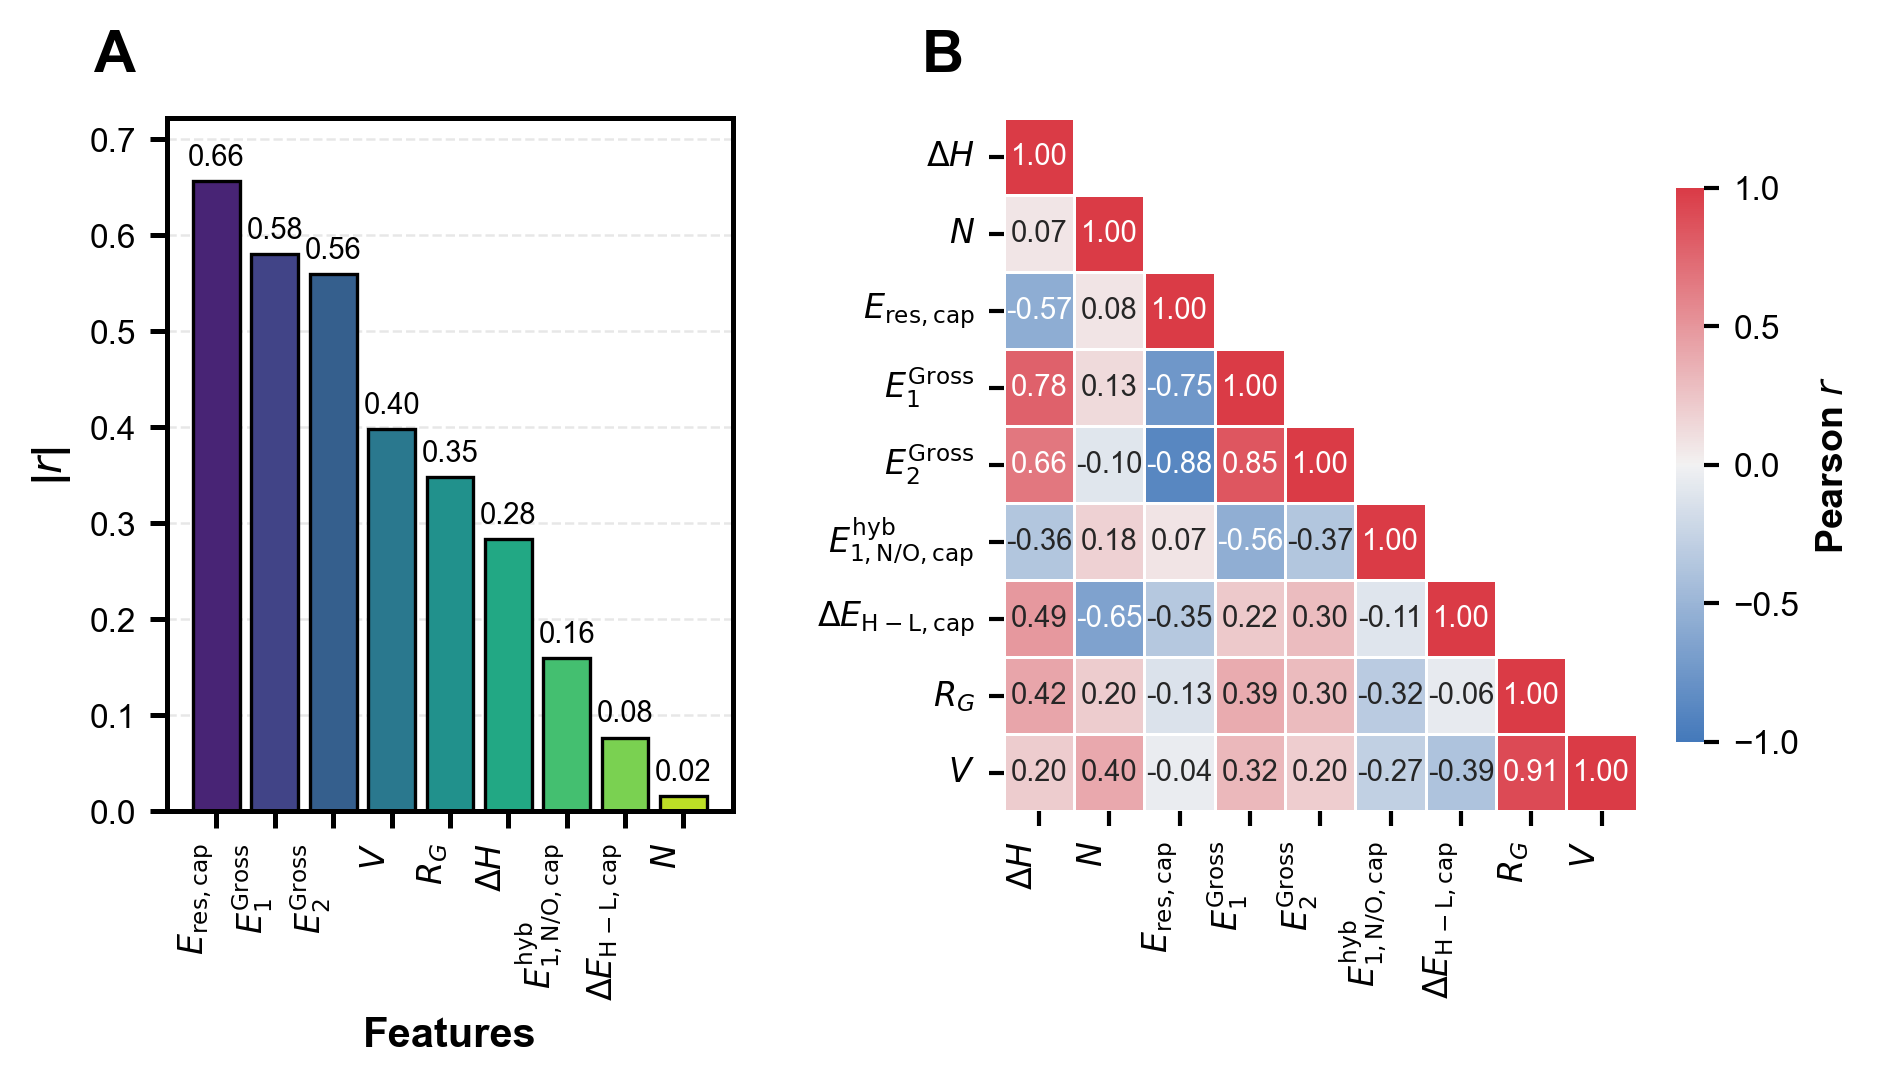

In [7]:
# Two-panel correlation figure
fig = plt.figure(figsize=(7, 3), dpi=300)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.4], wspace=0.4)

# ==================== PANEL A: BAR PLOT ====================
ax1 = fig.add_subplot(gs[0, 0])

# Generate colorblind-friendly viridis palette
n_bars = len(corr_abs)
colors = sns.color_palette("viridis", n_bars)

# Create bar plot
bars = ax1.bar(
    range(n_bars), 
    corr_abs.values, 
    color=colors,
    edgecolor='black', 
    linewidth=0.8
)

# Format x-axis: descriptor labels
ax1.set_xticks(range(n_bars))
ax1.set_xticklabels(
    corr_abs.index, 
    rotation=90, 
    ha='right',
    fontweight='bold', 
    fontsize=8
)

# Format y-axis: correlation coefficient with italic r
ax1.set_ylabel(r'|$r$|', fontweight='bold', fontsize=10)
ax1.set_xlabel('Features', fontweight='bold', fontsize=10)

# Add subtle grid for readability
ax1.yaxis.grid(True, alpha=0.3, linestyle='--', linewidth=0.6)
ax1.set_axisbelow(True)  # Place grid behind bars

# Set y-axis limits with 10% headroom for value labels
ax1.set_ylim(0, max(corr_abs.values) * 1.1)

# Format ticks
ax1.tick_params(axis='both', which='major', length=4, width=1.2, labelsize=8)

# Style plot border
for spine in ax1.spines.values():
    spine.set_linewidth(1.2)

# Add value labels above each bar
for bar, value in zip(bars, corr_abs.values):
    ax1.text(
        bar.get_x() + bar.get_width()/2,   # Center horizontally
        bar.get_height() + 0.01,           # Position above bar
        f'{value:.2f}',                    # Format to 2 decimal places
        ha='center', 
        va='bottom',
        fontsize=7, 
        color='black'
    )

# Add panel label
ax1.text(
    -0.13, 1.05, 'A', 
    transform=ax1.transAxes,
    fontsize=14, 
    fontweight='bold', 
    va='bottom', 
    ha='left'
)

# ==================== PANEL B: HEATMAP ====================
ax2 = fig.add_subplot(gs[0, 1])

# Create upper triangle mask (only show lower triangle + diagonal)
mask = np.triu(np.ones_like(heatmap_matrix, dtype=bool), k=1)

# Use blue-red diverging colormap (colorblind-friendly)
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Create heatmap
sns.heatmap(
    heatmap_matrix,
    mask=mask,
    annot=True,                    # Show correlation values
    fmt=".2f",                     # Format to 2 decimal places
    cmap=cmap,
    center=0,                      # Center colormap at zero
    vmin=-1,                       # Minimum correlation
    vmax=1,                        # Maximum correlation
    cbar_kws={
        'label': r'Pearson $r$',   # Colorbar label with italic r
        'shrink': 0.8,
        'ticks': [-1, -0.5, 0, 0.5, 1]
    },
    linewidths=0.3,                # Cell border width
    linecolor='white',             # Cell border color
    annot_kws={'fontsize': 7},
    square=False,                  # Allow non-square cells
    ax=ax2
)

# Format tick labels
ax2.set_xticklabels(
    ax2.get_xticklabels(), 
    rotation=90, 
    ha='right',
    fontweight='bold', 
    fontsize=8
)
ax2.set_yticklabels(
    ax2.get_yticklabels(), 
    rotation=0,
    fontweight='bold', 
    fontsize=8
)

# Format colorbar
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.set_label(r'Pearson $r$', fontsize=9, fontweight='bold')

# Allow heatmap to stretch horizontally
ax2.set_aspect('auto')

# Add panel label
ax2.text(
    -0.13, 1.05, 'B',
    transform=ax2.transAxes,
    fontsize=14, 
    fontweight='bold', 
    va='bottom', 
    ha='left'
)

# Save figure in both PNG and PDF formats
output_filename_png = 'combined_correlation_figure.png'
output_filename_pdf = 'combined_correlation_figure.pdf'

plt.savefig(
    output_filename_png, 
    dpi=300, 
    bbox_inches='tight',
    facecolor='white'
)
plt.savefig(
    output_filename_pdf, 
    dpi=300, 
    bbox_inches='tight',
    facecolor='white'
)

print(f"\nFigure saved as:")
print(f"  - {output_filename_png}")
print(f"  - {output_filename_pdf}")

plt.show()

## 8. Summary Statistics <a id="part1-8"></a>

Top descriptors ranked by absolute Pearson correlation with $T_{\mathrm{deblock}}$.

In [8]:
print("="*60)
print("CORRELATION ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset: {len(df)} samples")
print(f"Descriptors analyzed: {len(columns_to_normalize) - 1}")  # Exclude T_deblock

print("\n" + "="*60)
print("TOP 5 CORRELATIONS WITH DEBLOCKING TEMPERATURE")
print("="*60)

for i, (descriptor, corr_value) in enumerate(corr_abs.head(5).items(), 1):
    print(f"{i}. {descriptor:40s} |r| = {corr_value:.3f}")

print("="*60)

CORRELATION ANALYSIS SUMMARY

Dataset: 21 samples
Descriptors analyzed: 9

TOP 5 CORRELATIONS WITH DEBLOCKING TEMPERATURE
1. $E_{\mathrm{res,cap}}$                   |r| = 0.656
2. $E_{1}^{\mathrm{Gross}}$                 |r| = 0.580
3. $E_{2}^{\mathrm{Gross}}$                 |r| = 0.560
4. $V$                                      |r| = 0.398
5. $R_{G}$                                  |r| = 0.348


---

# Part II: Machine Learning Models

Develop and evaluate QSPR models for predicting $T_{\mathrm{deblock}}$ from quantum chemical descriptors. Four regression algorithms are compared across two feature sets (with and without BEBOP bond-energy descriptors).

**Models:** LASSO, Random Forest (RF), Gaussian Process (GPR), Gradient Boosting (GBR)

**Validation:** Leave-One-Out Cross-Validation (LOOCV, $n=19$) + external test set ($n=2$)

**Feature sets:** 9 descriptors (5 QM/RDKit + 4 BEBOP) vs. 5 descriptors (QM/RDKit only)

**Metrics:**

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}, \qquad R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}, \qquad \text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

---

## 9. Setup and Configuration <a id="part2-1"></a>

In [9]:
%matplotlib inline

# --- Python dependencies ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso, lasso_path
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 11,
    'axes.labelsize': 13,
    'axes.titlesize': 13,
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'figure.dpi': 150
})

print("Dependencies loaded successfully.")

Dependencies loaded successfully.


### 9.1 Configuration

Feature definitions, file paths, and hyperparameters. The 9-feature set includes 4 BEBOP bond-energy descriptors ($E_{\mathrm{res}}$, $E_1^{\mathrm{Gross}}$, $E_2^{\mathrm{Gross}}$, $E_{\mathrm{hyb}}$); the 5-feature set excludes them.

**Note:** $V$ and $R_G$ are strongly correlated ($r = 0.91$), so only $V$ is used in the ML models since it correlates more strongly with $T_{\text{deblock}}$ ($|r| = 0.40$ vs. $|r| = 0.35$).

**Hyperparameters:** LASSO regularization strength ($\lambda$) is selected by LOOCV. RF and GBR use standard scikit-learn defaults (RF: 500 trees, full depth; GBR: 500 stages, max_depth=2, learning_rate=0.05, subsample=0.7).

In [10]:
# =============================================================================
# Configuration: file paths, feature sets, hyperparameters
# =============================================================================

FILE_PATH = 'Paper 2 Data Oct 14th.xlsx'
ID_COL = 'Capping agent'
TARGET_COL = 'Tdeblock'

# Compounds held out for external validation
EXCLUDED_AGENTS = ['Octanone Oxime', '2Hydroxyethylmethacrylate']

# Feature columns WITH BEBOP descriptors (9 features)
FEATURE_COLS = [
    'delH (Jmol)',                     # Reaction enthalpy
    'N (Jmol)',                        # Nucleophilicity index
    'Resonance cap (Jmol)',            # BEBOP: Resonance energy
    'Gross bond 1 (Jmol)',             # BEBOP: Gross bond energy 1
    'Gross bond 2 (Jmol)',             # BEBOP: Gross bond energy 2
    'N/O - H hyb (cap) (Jmol)',        # BEBOP: Hybridization energy of capping agent
    'homo lumo energy gap cap (Jmol)', # HOMO-LUMO gap
    'Molar Volume (m3/mol)',           # Molar volume
    'Urethane Cat'                     # Urethane categorical
]

# Feature columns WITHOUT BEBOP descriptors (5 features)
FEATURE_COLS_NO_BEBOP = [
    'delH (Jmol)',
    'N (Jmol)',
    'homo lumo energy gap cap (Jmol)',
    'Molar Volume (m3/mol)',
    'Urethane Cat'
]

# LaTeX-formatted labels for plots
FEATURE_LABELS = [
    r'$\Delta H$',
    r'$N$',
    r'$E_{res,cap}$',
    r'$E_1^{Gross}$',
    r'$E_2^{Gross}$',
    r'$E_{1,N/O,(cap)}^{hyb}$',
    r'$\Delta E_{H-L,(cap)}$',
    r'$V$',
    r'$f(Urethane)$'
]

FEATURE_LABELS_NO_BEBOP = [
    r'$\Delta H$',
    r'$N$',
    r'$\Delta E_{H-L,(cap)}$',
    r'$V$',
    r'$f(Urethane)$'
]

# Shared hyperparameters
RANDOM_STATE = 42
MAX_ITER = 1_000_000     # LASSO convergence
TOLERANCE = 1e-6         # LASSO tolerance
FIG_DPI = 300            # Figure resolution

print(f"Features WITH BEBOP:    {len(FEATURE_COLS)}")
print(f"Features WITHOUT BEBOP: {len(FEATURE_COLS_NO_BEBOP)}")
print(f"BEBOP-specific features: {len(FEATURE_COLS) - len(FEATURE_COLS_NO_BEBOP)}")

Features WITH BEBOP:    9
Features WITHOUT BEBOP: 5
BEBOP-specific features: 4


### 9.2 Utility Functions

Helper functions: `evaluate_model` (RMSE, R²), `run_loocv` (generic LOOCV loop), `plot_parity` (predicted vs. experimental with ±RMSE band), `plot_feature_importance` (horizontal bar chart), `compute_gdf` (Generalized Degrees of Freedom via numerical perturbation), `compute_gpr_hat_trace` (GPR effective degrees of freedom via hat matrix trace).

In [11]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display regression performance metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}: RMSE = {rmse:.2f} °C | R² = {r2:.3f}")
    return {'rmse': rmse, 'mae': mae, 'r2': r2}


def run_loocv(X, y, model_class, model_params):
    """Run Leave-One-Out Cross-Validation for a given model."""
    loo = LeaveOneOut()
    y_pred = np.zeros_like(y)
    for train_idx, test_idx in loo.split(X):
        model = model_class(**model_params)
        model.fit(X[train_idx], y[train_idx])
        y_pred[test_idx] = model.predict(X[test_idx])
    return y_pred


def plot_parity(y_true, y_pred, rmse, r2, title, color='C0', ax=None,
                y_test_true=None, y_test_pred=None, lims=None):
    """Generate a parity plot with RMSE band. Held-out test points shown as stars."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Axis limits: use provided lims or compute from data
    if lims is not None:
        data_min, data_max = lims
    else:
        all_true = np.concatenate([y_true, y_test_true]) if y_test_true is not None else y_true
        all_pred = np.concatenate([y_pred, y_test_pred]) if y_test_pred is not None else y_pred
        data_min = min(all_true.min(), all_pred.min()) - 5
        data_max = max(all_true.max(), all_pred.max()) + 5

    # Training data (circles)
    ax.scatter(y_true, y_pred, c=color, edgecolor='k', alpha=0.8, s=60,
               zorder=3, label='Training (LOOCV)')

    # Held-out test data (stars)
    if y_test_true is not None and y_test_pred is not None:
        ax.scatter(y_test_true, y_test_pred, marker='*', c=color, edgecolor='k',
                   s=200, linewidths=0.8, zorder=4, label='Held-out test')

    ax.plot([data_min, data_max], [data_min, data_max], 'k--', lw=1.5, zorder=2)
    ax.fill_between(
        [data_min, data_max],
        [data_min - rmse, data_max - rmse],
        [data_min + rmse, data_max + rmse],
        color=color, alpha=0.15, zorder=1
    )
    ax.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.1f} °C',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_xlabel(r'Experimental $T_{\mathrm{deblock}}$ (°C)')
    ax.set_ylabel(r'Predicted $T_{\mathrm{deblock}}$ (°C)')
    ax.set_title(title)
    ax.set_xlim(data_min, data_max)
    ax.set_ylim(data_min, data_max)
    ax.set_aspect('equal')
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    return ax


def plot_feature_importance(importances, labels, title, ylabel='Importance', ax=None):
    """Generate a horizontal bar chart of feature importances."""
    sorted_idx = np.argsort(importances)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    y_pos = np.arange(len(importances))
    ax.barh(y_pos, importances[sorted_idx], color='#56B4E9', edgecolor='k', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([labels[i] for i in sorted_idx])
    ax.set_xlabel(ylabel)
    ax.set_title(title)
    ax.invert_yaxis()
    return ax



def compute_gdf(model_class, model_params, X, y, epsilon=1e-3):
    """
    Compute Generalized Degrees of Freedom (GDF) via numerical perturbation.

    Implements the Ye (1998) estimator:
        GDF = sum_i  d(y_hat_i) / d(y_i)
    approximated by finite differences. Each training response y_i is perturbed
    by +epsilon, the model is refit, and the change in prediction at index i is
    recorded. The sum of these sensitivities yields the effective number of
    parameters.

    Reference:
        J. Ye, "On Measuring and Correcting the Effects of Data Mining and
        Model Selection," J. Am. Stat. Assoc. 93, 120–131 (1998).
        DOI: 10.1080/01621459.1998.10474094

    Parameters
    ----------
    model_class : sklearn estimator class
    model_params : dict
    X : ndarray, shape (n, p)
    y : ndarray, shape (n,)
    epsilon : float, perturbation magnitude

    Returns
    -------
    gdf : float, effective degrees of freedom
    """
    base_model = model_class(**model_params)
    base_model.fit(X, y)
    base_preds = base_model.predict(X)

    gdf = 0.0
    for i in range(len(y)):
        y_pert = y.copy()
        y_pert[i] += epsilon
        pert_model = model_class(**model_params)
        pert_model.fit(X, y_pert)
        gdf += (pert_model.predict(X[i:i+1])[0] - base_preds[i]) / epsilon
    return gdf


def compute_gpr_hat_trace(gpr_fitted, X):
    """
    Compute effective degrees of freedom for a fitted GaussianProcessRegressor
    as the trace of the hat (smoother) matrix:

        df_eff = tr[ K_signal @ (K_signal + sigma^2 I)^{-1} ]

    where K_signal is the signal covariance (excluding observation noise) and
    sigma^2 is the learned noise variance from the WhiteKernel.

    This is the standard measure of model complexity for kernel smoothers and
    Gaussian processes (Rasmussen & Williams, 2006, §5.4.1).

    Reference:
        C. E. Rasmussen and C. K. I. Williams, "Gaussian Processes for Machine
        Learning," MIT Press (2006). ISBN 026218253X.

    Parameters
    ----------
    gpr_fitted : GaussianProcessRegressor (already fitted)
    X : ndarray, shape (n, p), training features

    Returns
    -------
    df_eff : float, effective degrees of freedom
    """
    n = X.shape[0]
    # Signal kernel: ConstantKernel * RBF (k1 component of sum kernel)
    K_signal = gpr_fitted.kernel_.k1(X)
    # Noise variance: WhiteKernel (k2 component of sum kernel)
    noise_var = gpr_fitted.kernel_.k2.noise_level
    # Hat matrix: H = K_signal @ (K_signal + sigma^2 I)^{-1}
    K_full = K_signal + noise_var * np.eye(n)
    H = K_signal @ np.linalg.inv(K_full)
    return np.trace(H)


print("Utility functions defined.")

Utility functions defined.


## 10. Data Loading and Preprocessing <a id="part2-2"></a>

Load dataset, validate columns, and split into training ($n=19$) and external test ($n=2$: Octanone Oxime, 2-Hydroxyethylmethacrylate).

In [12]:
# Load dataset and split into training / external test sets
df = pd.read_excel(FILE_PATH)

# Validate required columns
required_cols = FEATURE_COLS + [TARGET_COL, ID_COL]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns: {missing_cols}")

# Remove rows with missing values in any feature or target column
df = df.dropna(subset=FEATURE_COLS + [TARGET_COL])
print(f"Dataset: {df.shape[0]} compounds × {df.shape[1]} columns")

# Split into training and external test sets
test_df = df[df[ID_COL].isin(EXCLUDED_AGENTS)].copy()
train_df = df[~df[ID_COL].isin(EXCLUDED_AGENTS)].copy()

agents_str = ", ".join(EXCLUDED_AGENTS)
print(f"Training set: {len(train_df)} compounds")
print(f"External test set: {len(test_df)} compounds ({agents_str})")

Dataset: 21 compounds × 74 columns
Training set: 19 compounds
External test set: 2 compounds (Octanone Oxime, 2Hydroxyethylmethacrylate)


### 10.1 Feature Scaling

Z-score normalization with separate scalers for BEBOP and non-BEBOP feature sets. Test set transformed using training-set statistics.

In [13]:
# --- Standardize WITH BEBOP features (9 descriptors) ---
train_df_clean = train_df.copy()

X_train = train_df_clean[FEATURE_COLS].to_numpy(dtype=float)
y_train = train_df_clean[TARGET_COL].to_numpy(dtype=float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(f"Training matrix (BEBOP):     {X_train_scaled.shape}")
print(f"Target range: {y_train.min():.1f} °C – {y_train.max():.1f} °C")

# --- Standardize WITHOUT BEBOP features (5 descriptors) ---
train_df_no_bebop = train_df.copy()

X_train_no_bebop = train_df_no_bebop[FEATURE_COLS_NO_BEBOP].to_numpy(dtype=float)
y_train_no_bebop = train_df_no_bebop[TARGET_COL].to_numpy(dtype=float)

scaler_no_bebop = StandardScaler()
X_train_no_bebop_scaled = scaler_no_bebop.fit_transform(X_train_no_bebop)

print(f"Training matrix (non-BEBOP): {X_train_no_bebop_scaled.shape}")

# --- Transform external test set using training-set statistics ---
test_df_clean = test_df.dropna(subset=FEATURE_COLS + [TARGET_COL]).copy()
X_test = test_df_clean[FEATURE_COLS].to_numpy(dtype=float)
y_test = test_df_clean[TARGET_COL].to_numpy(dtype=float)
X_test_scaled = scaler.transform(X_test)
X_test_no_bebop_scaled = scaler_no_bebop.transform(
    test_df_clean[FEATURE_COLS_NO_BEBOP].to_numpy(dtype=float)
)
print(f"\nExternal test set: {len(y_test)} compounds prepared for plotting")

Training matrix (BEBOP):     (19, 9)
Target range: 227.0 °C – 323.0 °C
Training matrix (non-BEBOP): (19, 5)

External test set: 2 compounds prepared for plotting


## 11. LASSO Regression <a id="part2-3"></a>

LASSO (Least Absolute Shrinkage and Selection Operator) performs simultaneous regression and feature selection via the L1 penalty $\|\boldsymbol{\beta}\|_1$. The regularization strength $\lambda$ is selected by LOOCV over the full regularization path. Because LASSO yields an explicit linear equation in the standardized descriptors, the resulting model is fully interpretable.


In [14]:
# =============================================================================
# Section 11: LASSO Regression (with BEBOP descriptors)
# λ selected via LOOCV over the full regularization path
# =============================================================================
print("=" * 60)
print("LASSO REGRESSION (WITH BEBOP)")
print("=" * 60)

loo = LeaveOneOut()

# Step 1: Select optimal λ via LOOCV
lasso_cv = LassoCV(
    cv=loo, max_iter=MAX_ITER, tol=TOLERANCE,
    random_state=RANDOM_STATE, n_jobs=-1
)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha = lasso_cv.alpha_
print(f"\nOptimal λ = {best_alpha:.4e}")

# Step 2: Fit final model at optimal λ
lasso_final = Lasso(alpha=best_alpha, max_iter=MAX_ITER, tol=TOLERANCE)
lasso_final.fit(X_train_scaled, y_train)

# Step 3: Generate LOOCV predictions for parity plot
lasso_for_cv = Lasso(alpha=best_alpha, max_iter=MAX_ITER, tol=TOLERANCE)
y_pred_lasso = cross_val_predict(lasso_for_cv, X_train_scaled, y_train, cv=loo, n_jobs=-1)

# Step 4: Evaluate LOOCV performance
print("\n--- LOOCV Performance ---")
lasso_metrics = evaluate_model(y_train, y_pred_lasso, "LASSO")

# Step 5: Report selected features and model equation
coefs = lasso_final.coef_
nonzero_idx = np.where(np.abs(coefs) > 1e-8)[0]
print(f"\nSelected features: {len(nonzero_idx)}/{len(FEATURE_COLS)}")

coef_df = pd.DataFrame({
    'Feature': [FEATURE_LABELS[i] for i in nonzero_idx],
    'Coefficient': coefs[nonzero_idx],
    '|Coefficient|': np.abs(coefs[nonzero_idx])
}).sort_values('|Coefficient|', ascending=False)
display(coef_df)

# Explicit linear equation in standardized features
intercept = lasso_final.intercept_
terms = []
for idx in nonzero_idx:
    sign = '+' if coefs[idx] >= 0 else ''
    terms.append(f"{sign}{coefs[idx]:.4f} \u00d7 {FEATURE_LABELS[idx]}")
equation = f"T_deblock = {intercept:.4f} " + " ".join(terms)
print(f"\n--- LASSO Equation (standardized features) ---")
print(equation)

n_params_lasso = len(nonzero_idx) + 1
print(f"\nEffective parameters: {n_params_lasso} ({len(nonzero_idx)} coefficients + 1 intercept)")

# Step 6: Predict held-out test compounds
y_test_pred_lasso = lasso_final.predict(X_test_scaled)

LASSO REGRESSION (WITH BEBOP)

Optimal λ = 1.0630e-01

--- LOOCV Performance ---
LASSO: RMSE = 11.71 °C | R² = 0.845

Selected features: 8/9


,Feature,Coefficient,|Coefficient|
5,"$E_{1,N/O,(cap)}^{hyb}$",115.424079,115.424079
7,$f(Urethane)$,107.717078,107.717078
0,$\Delta H$,35.636374,35.636374
6,$V$,16.545579,16.545579
2,"$E_{res,cap}$",-5.955816,5.955816
3,$E_1^{Gross}$,4.801787,4.801787
1,$N$,2.459190,2.459190
4,$E_2^{Gross}$,-0.488301,0.488301



--- LASSO Equation (standardized features) ---
T_deblock = 277.0447 +35.6364 × $\Delta H$ +2.4592 × $N$ -5.9558 × $E_{res,cap}$ +4.8018 × $E_1^{Gross}$ -0.4883 × $E_2^{Gross}$ +115.4241 × $E_{1,N/O,(cap)}^{hyb}$ +16.5456 × $V$ +107.7171 × $f(Urethane)$

Effective parameters: 9 (8 coefficients + 1 intercept)


### 11.1 LASSO Diagnostic Plots

**(A)** Parity plot, **(B)** coefficient path vs. $\log_{10}(\lambda)$, **(C)** LOOCV MSE vs. $\lambda$.

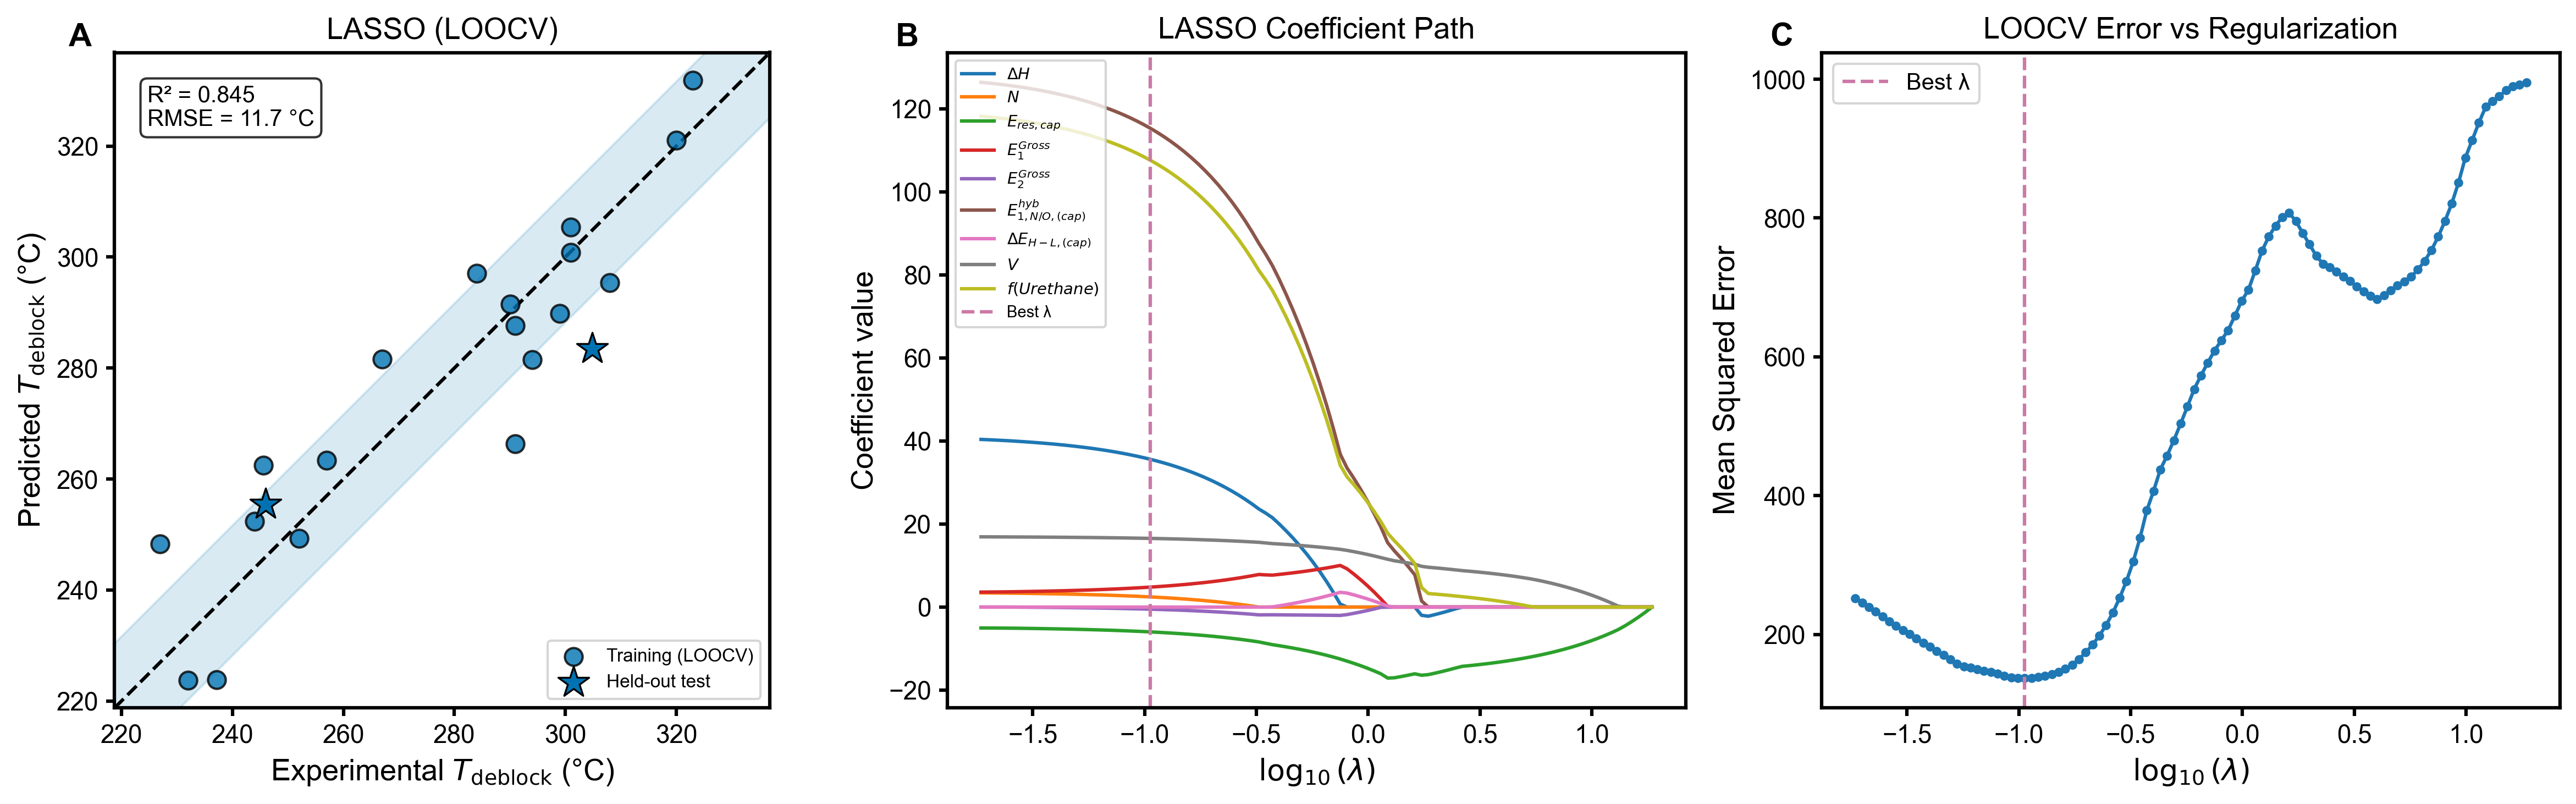

In [15]:
# Three-panel LASSO diagnostic figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=300)

# (a) Parity plot
plot_parity(y_train, y_pred_lasso, lasso_metrics['rmse'], lasso_metrics['r2'],
            'LASSO (LOOCV)', color='#0072B2', ax=axes[0],
            y_test_true=y_test, y_test_pred=y_test_pred_lasso)

# (b) Coefficient path
alphas_path, coefs_path, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)
log_alphas = np.log10(alphas_path)
for i in range(coefs_path.shape[0]):
    axes[1].plot(log_alphas, coefs_path[i, :], lw=1.5, label=FEATURE_LABELS[i])
axes[1].axvline(np.log10(best_alpha), color='#CC79A7', ls='--', lw=1.5, label=f'Best λ')
axes[1].set_xlabel(r'$\log_{10}(\lambda)$')
axes[1].set_ylabel('Coefficient value')
axes[1].set_title('LASSO Coefficient Path')
axes[1].legend(fontsize=7, loc='upper left', frameon=True)

# (c) MSE vs lambda
mean_mse = np.mean(lasso_cv.mse_path_, axis=1)
axes[2].plot(np.log10(lasso_cv.alphas_), mean_mse, 'o-', ms=3, lw=1.5)
axes[2].axvline(np.log10(best_alpha), color='#CC79A7', ls='--', lw=1.5, label=f'Best λ')
axes[2].set_xlabel(r'$\log_{10}(\lambda)$')
axes[2].set_ylabel('Mean Squared Error')
axes[2].set_title('LOOCV Error vs Regularization')
axes[2].legend(fontsize=10)

# Add panel labels
axes[0].text(-0.07, 1.00, 'A', transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')
axes[1].text(-0.07, 1.00, 'B', transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')
axes[2].text(-0.07, 1.00, 'C', transform=axes[2].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.show()

### 11.2 LASSO Without BEBOP Descriptors

Retrain using only the 5 non-BEBOP features to isolate the contribution of BEBOP descriptors.

In [16]:
print("=" * 60)
print("LASSO REGRESSION (WITHOUT BEBOP)")
print("=" * 60)

loo_nb = LeaveOneOut()

lasso_cv_no_bebop = LassoCV(
    cv=loo_nb, max_iter=MAX_ITER, tol=TOLERANCE,
    random_state=RANDOM_STATE, n_jobs=-1
)
lasso_cv_no_bebop.fit(X_train_no_bebop_scaled, y_train_no_bebop)
best_alpha_no_bebop = lasso_cv_no_bebop.alpha_
print(f"\nOptimal λ = {best_alpha_no_bebop:.4e}")

lasso_final_no_bebop = Lasso(alpha=best_alpha_no_bebop, max_iter=MAX_ITER, tol=TOLERANCE)
lasso_final_no_bebop.fit(X_train_no_bebop_scaled, y_train_no_bebop)

lasso_nb_cv = Lasso(alpha=best_alpha_no_bebop, max_iter=MAX_ITER, tol=TOLERANCE)
y_pred_lasso_no_bebop = cross_val_predict(
    lasso_nb_cv, X_train_no_bebop_scaled, y_train_no_bebop, cv=loo_nb, n_jobs=-1
)

print("\n--- LOOCV Performance ---")
lasso_metrics_no_bebop = evaluate_model(y_train_no_bebop, y_pred_lasso_no_bebop, "LASSO (no BEBOP)")

coefs_nb = lasso_final_no_bebop.coef_
nonzero_idx_nb = np.where(np.abs(coefs_nb) > 1e-8)[0]
print(f"\nSelected features: {len(nonzero_idx_nb)}/{len(FEATURE_COLS_NO_BEBOP)}")

coef_df_nb = pd.DataFrame({
    'Feature': [FEATURE_LABELS_NO_BEBOP[i] for i in nonzero_idx_nb],
    'Coefficient': coefs_nb[nonzero_idx_nb],
    '|Coefficient|': np.abs(coefs_nb[nonzero_idx_nb])
}).sort_values('|Coefficient|', ascending=False)
display(coef_df_nb)

# Print LASSO equation (no BEBOP)
intercept_nb = lasso_final_no_bebop.intercept_
terms_nb = []
for idx in nonzero_idx_nb:
    sign = '+' if coefs_nb[idx] >= 0 else ''
    terms_nb.append(f"{sign}{coefs_nb[idx]:.4f} × {FEATURE_LABELS_NO_BEBOP[idx]}")
equation_nb = f"T_deblock = {intercept_nb:.4f} " + " ".join(terms_nb)
print(f"\n--- LASSO Equation (standardized features, no BEBOP) ---")
print(equation_nb)

# Number of effective parameters
n_params_lasso_nb = len(nonzero_idx_nb) + 1
print(f"\nEffective parameters: {n_params_lasso_nb} ({len(nonzero_idx_nb)} coefficients + 1 intercept)")

LASSO REGRESSION (WITHOUT BEBOP)

Optimal λ = 1.1621e+00

--- LOOCV Performance ---
LASSO (no BEBOP): RMSE = 30.94 °C | R² = -0.084

Selected features: 4/5


,Feature,Coefficient,|Coefficient|
2,$V$,16.066129,16.066129
1,"$\Delta E_{H-L,(cap)}$",8.593449,8.593449
3,$f(Urethane)$,3.031591,3.031591
0,$N$,0.289245,0.289245



--- LASSO Equation (standardized features, no BEBOP) ---
T_deblock = 277.0447 +0.2892 × $N$ +8.5934 × $\Delta E_{H-L,(cap)}$ +16.0661 × $V$ +3.0316 × $f(Urethane)$

Effective parameters: 5 (4 coefficients + 1 intercept)


## 12. Random Forest Regression <a id="part2-4"></a>

Random Forest builds an ensemble of 500 decision trees trained on bootstrap samples with random feature subsets. Predictions are averaged across trees, and feature importance is estimated from the mean decrease in Gini impurity. RF serves as a non-parametric, non-linear baseline.


In [17]:
# =============================================================================
# Section 12: Random Forest (with BEBOP descriptors)
# 500 trees, full depth, bootstrap aggregation
# =============================================================================
print("=" * 60)
print("RANDOM FOREST REGRESSION")
print("=" * 60)

rf_params = {
    'n_estimators': 500,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

# LOOCV
y_pred_rf = run_loocv(X_train_scaled, y_train, RandomForestRegressor, rf_params)

# Fit final model
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train_scaled, y_train)

print("\n--- LOOCV Performance ---")
rf_metrics = evaluate_model(y_train, y_pred_rf, "Random Forest")

# Effective parameters via Generalized Degrees of Freedom (Ye, 1998)
print("\nComputing GDF for Random Forest (n=19 perturbations)...")
n_params_rf = compute_gdf(RandomForestRegressor, rf_params, X_train_scaled, y_train)
print(f"Effective parameters (GDF): {n_params_rf:.1f}")

# Test set predictions
y_test_pred_rf = rf_model.predict(X_test_scaled)

RANDOM FOREST REGRESSION

--- LOOCV Performance ---
Random Forest: RMSE = 24.88 °C | R² = 0.299

Computing GDF for Random Forest (n=19 perturbations)...
Effective parameters (GDF): 12.2


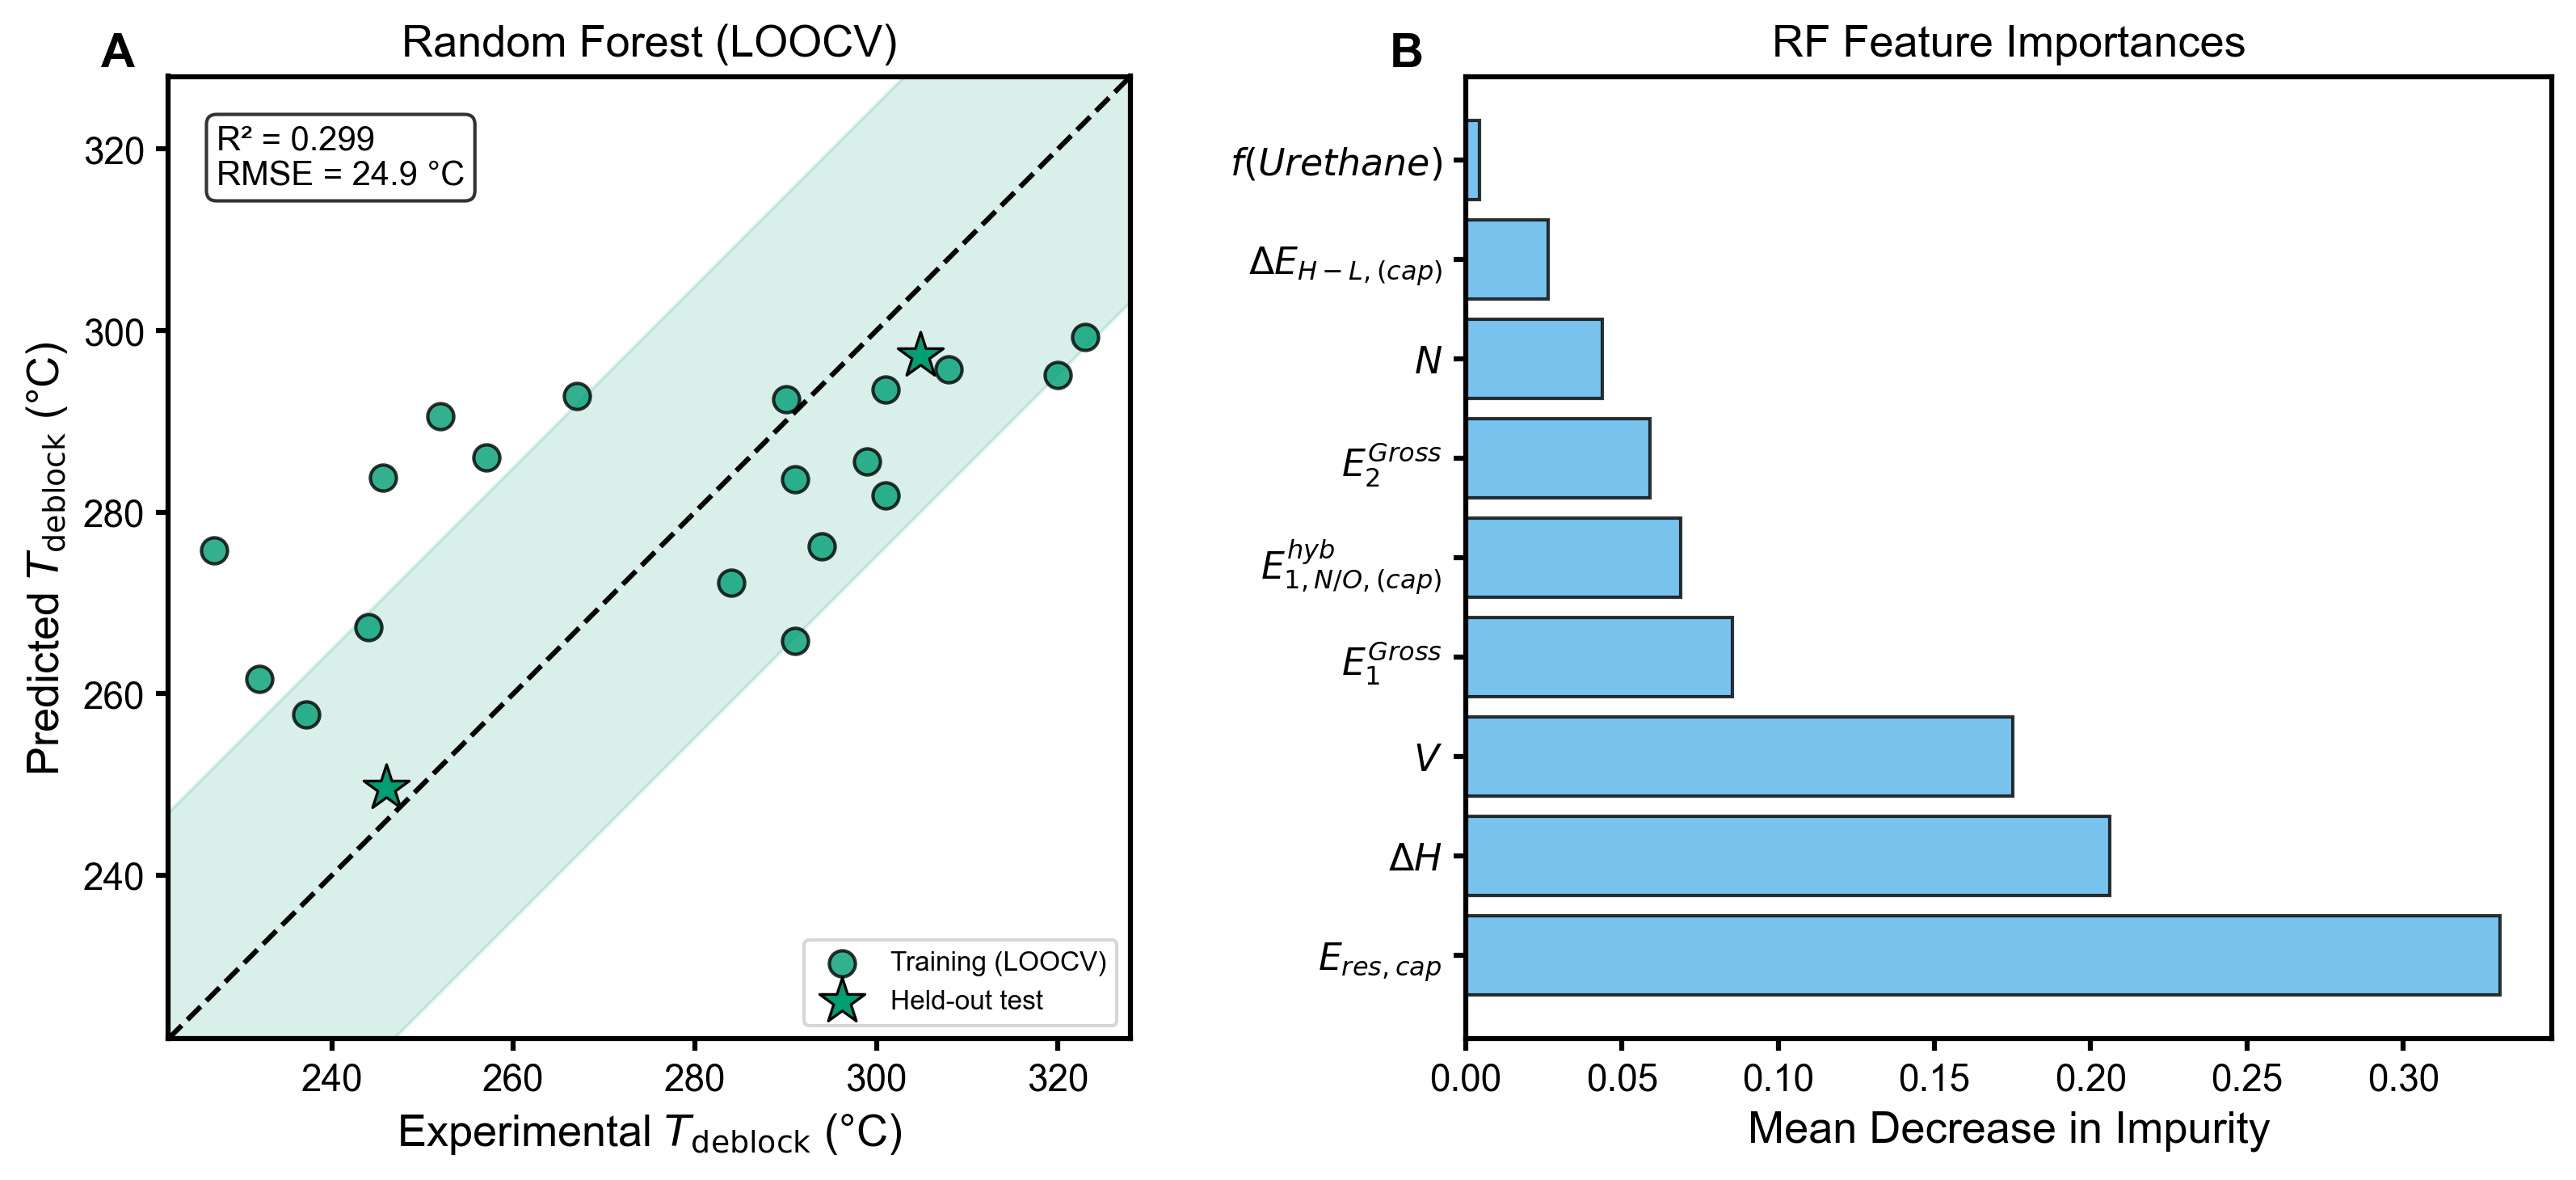

In [18]:
# Parity plot and Gini impurity-based feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), dpi=300)

plot_parity(y_train, y_pred_rf, rf_metrics['rmse'], rf_metrics['r2'],
            'Random Forest (LOOCV)', color='#009E73', ax=ax1,
            y_test_true=y_test, y_test_pred=y_test_pred_rf)

plot_feature_importance(rf_model.feature_importances_, FEATURE_LABELS,
                        'RF Feature Importances', ylabel='Mean Decrease in Impurity', ax=ax2)

# Add panel labels
ax1.text(-0.07, 1.00, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')
ax2.text(-0.07, 1.00, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.show()

## 13. Gaussian Process Regression <a id="part2-5"></a>

GPR with composite kernel: $k(\mathbf{x}, \mathbf{x}^\prime) = \sigma_f^2 \, \mathrm{RBF}(\mathbf{x}, \mathbf{x}^\prime) + \sigma_n^2 \delta_{\mathbf{x}\mathbf{x}^\prime}$. The anisotropic RBF kernel uses automatic relevance determination (ARD), assigning a separate length scale $\ell_j$ to each feature. Hyperparameters are optimized via log marginal likelihood. Feature importance is assessed by permutation importance ($n=100$ repeats).

LOOCV refits kernel hyperparameters in each fold to avoid information leakage.

In [19]:
# =============================================================================
# Section 13: Gaussian Process Regression (with BEBOP descriptors)
# Anisotropic RBF kernel with ARD; WhiteKernel for observation noise
# =============================================================================
print("=" * 60)
print("GAUSSIAN PROCESS REGRESSION")
print("=" * 60)

n_features = X_train_scaled.shape[1]

kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) *
    RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-1, 10)) +
    WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 10))
)

gpr_params = {
    'kernel': kernel,
    'alpha': 0.0,
    'normalize_y': True,
    'n_restarts_optimizer': 3,
    'random_state': RANDOM_STATE
}

# LOOCV
loo = LeaveOneOut()
y_pred_gpr = np.zeros_like(y_train)
for train_idx, test_idx in loo.split(X_train_scaled):
    gpr_cv = GaussianProcessRegressor(**gpr_params)
    gpr_cv.fit(X_train_scaled[train_idx], y_train[train_idx])
    y_pred_gpr[test_idx] = gpr_cv.predict(X_train_scaled[test_idx])

# Fit final model
gpr_model = GaussianProcessRegressor(**gpr_params)
gpr_model.fit(X_train_scaled, y_train)

print("\n--- LOOCV Performance ---")
gpr_metrics = evaluate_model(y_train, y_pred_gpr, "GPR")
print(f"\nOptimized kernel: {gpr_model.kernel_}")

# Effective parameters via hat matrix trace (Rasmussen & Williams, 2006)
n_params_gpr = compute_gpr_hat_trace(gpr_model, X_train_scaled)
n_kernel_hp = len(gpr_model.kernel_.theta)
print(f"\nHat matrix trace (df_eff): {n_params_gpr:.2f}")
print(f"Kernel hyperparameters optimized: {n_kernel_hp}")

# Test set predictions
y_test_pred_gpr = gpr_model.predict(X_test_scaled)

GAUSSIAN PROCESS REGRESSION

--- LOOCV Performance ---
GPR: RMSE = 16.38 °C | R² = 0.696

Optimized kernel: 1.23**2 * RBF(length_scale=[1.23, 10, 1.71, 10, 4.55, 3.99, 10, 3.49, 10]) + WhiteKernel(noise_level=0.0248)

Hat matrix trace (df_eff): 13.47
Kernel hyperparameters optimized: 11


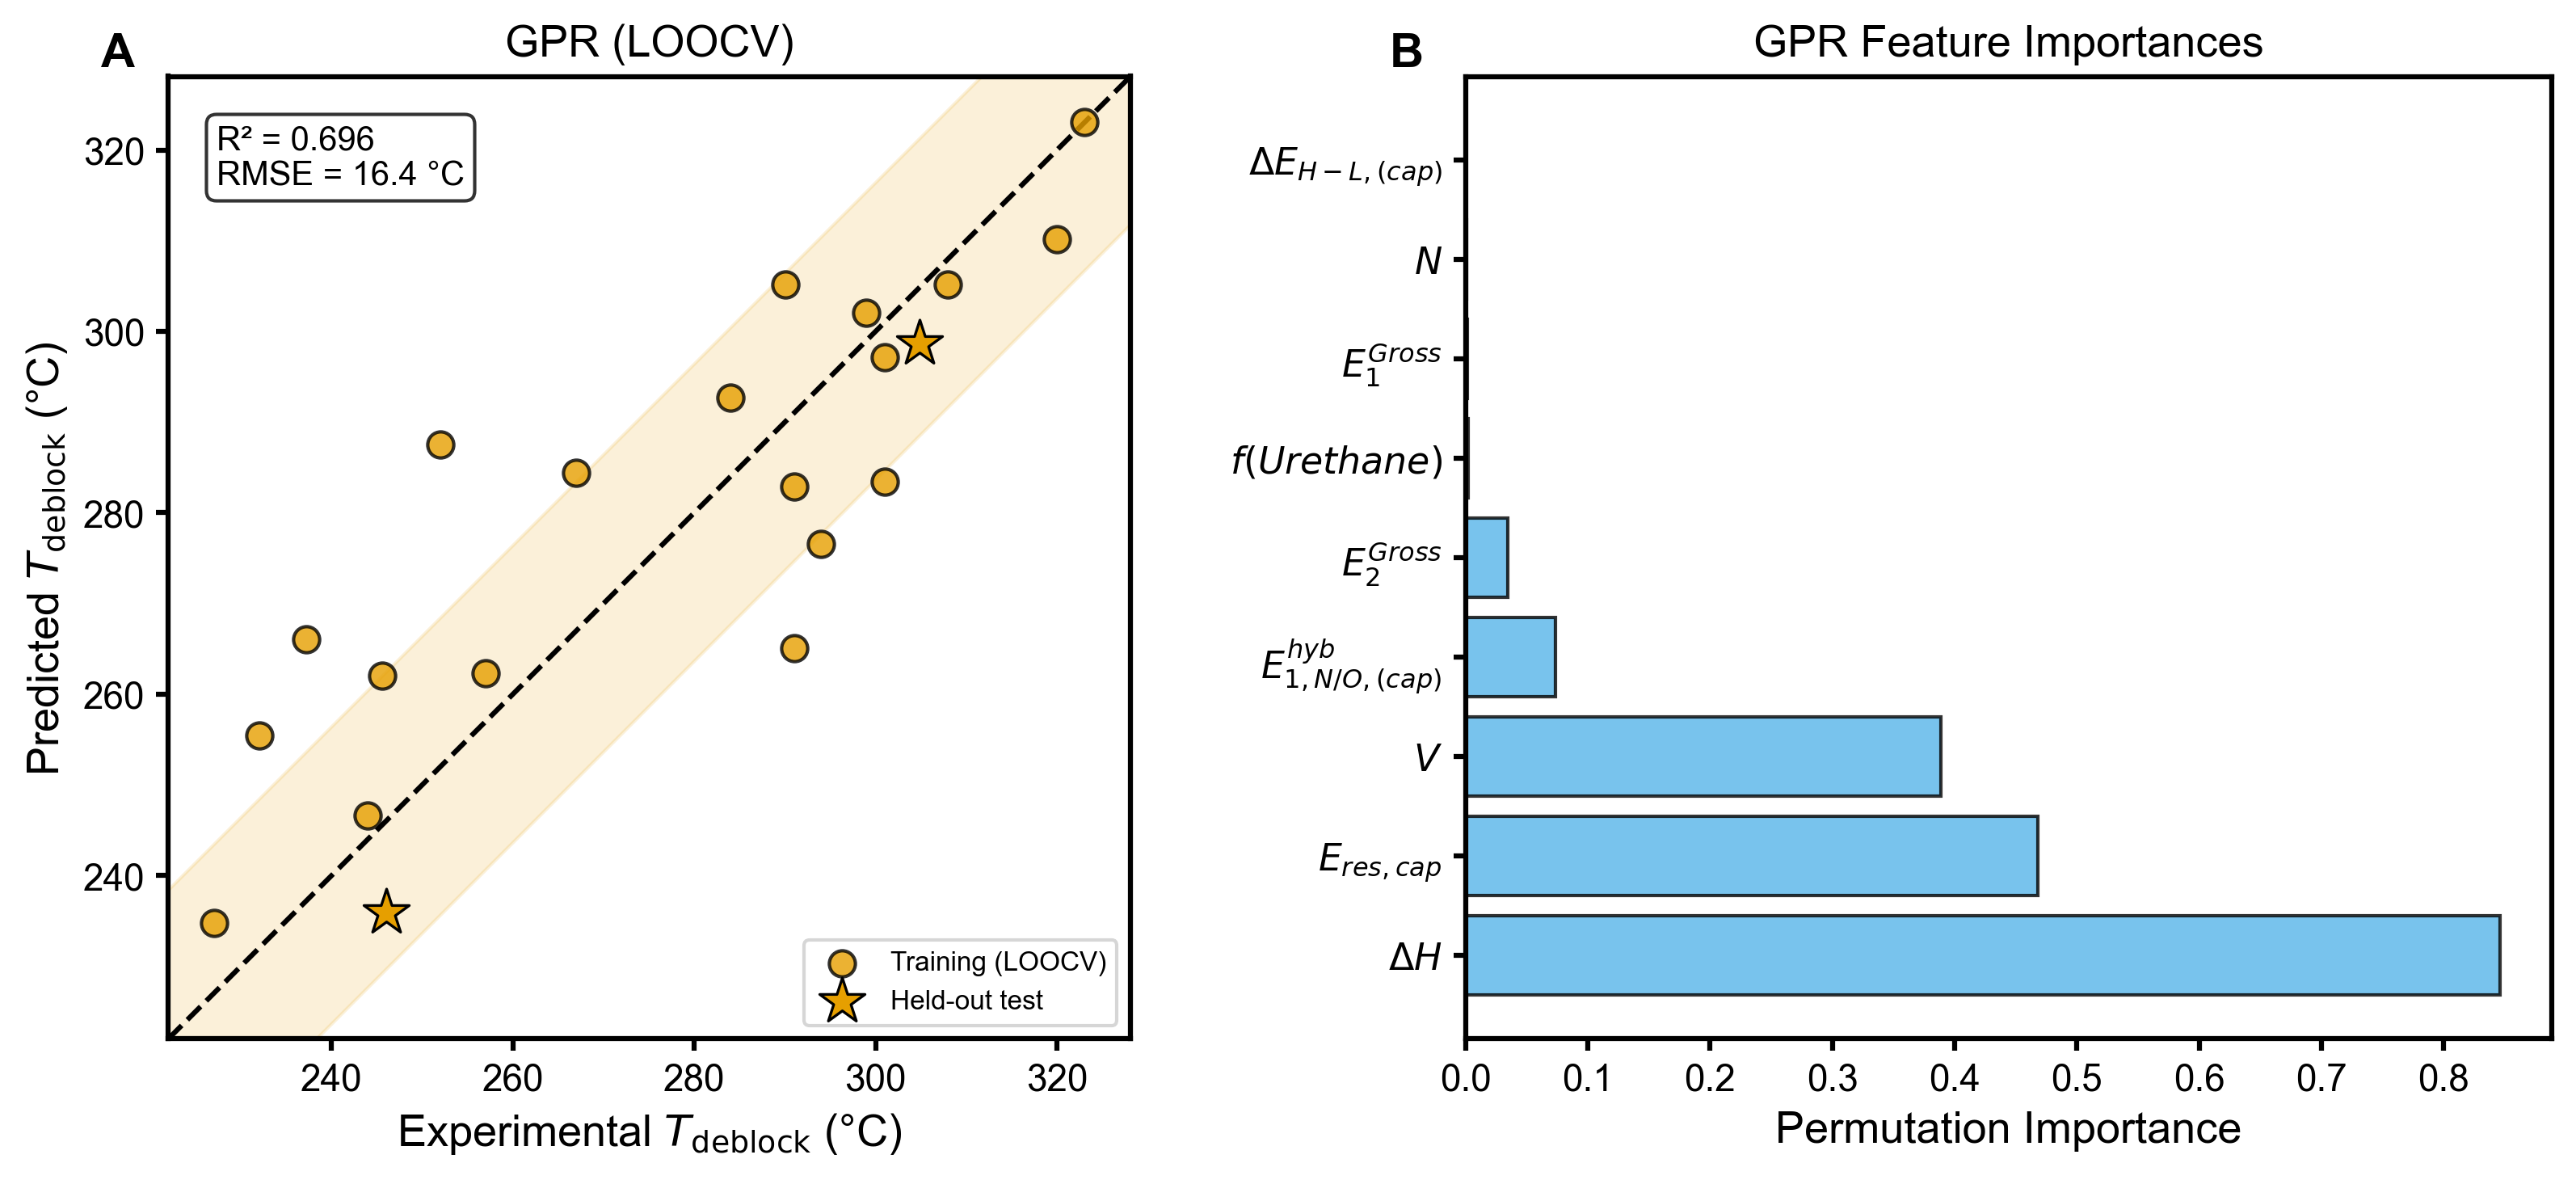

In [20]:
# Parity plot and permutation importance (n=100 repeats)
perm_result = permutation_importance(
    gpr_model, X_train_scaled, y_train,
    n_repeats=100, random_state=RANDOM_STATE, n_jobs=-1
)
gpr_importances = perm_result.importances_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), dpi=300)

plot_parity(y_train, y_pred_gpr, gpr_metrics['rmse'], gpr_metrics['r2'],
            'GPR (LOOCV)', color='#E69F00', ax=ax1,
            y_test_true=y_test, y_test_pred=y_test_pred_gpr)

plot_feature_importance(gpr_importances, FEATURE_LABELS,
                        'GPR Feature Importances', ylabel='Permutation Importance', ax=ax2)

# Add panel labels
ax1.text(-0.07, 1.00, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')
ax2.text(-0.07, 1.00, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.show()

In [21]:
# GPR ARD length scales: small length scale = high feature relevance
fitted_kernel = gpr_model.kernel_
signal_kernel = fitted_kernel.k1  # ConstantKernel * RBF
rbf_kernel = signal_kernel.k2     # RBF with per-feature length scales
noise_kernel = fitted_kernel.k2   # WhiteKernel

length_scales = rbf_kernel.length_scale
relevance = 1.0 / length_scales   # Inverse length scale ∝ relevance

# Extract optimization bounds (may be a single pair or per-feature)
bounds = rbf_kernel.length_scale_bounds
if hasattr(bounds[0], '__len__'):
    ls_lower, ls_upper = bounds[0][0], bounds[0][1]
else:
    ls_lower, ls_upper = bounds[0], bounds[1]

# Features pinned at the upper bound are effectively inactive
is_active = length_scales < 0.99 * ls_upper

print("=" * 60)
print("GPR KERNEL ANALYSIS — ARD Length Scales")
print("=" * 60)
print(f"\nFitted kernel: {fitted_kernel}")
print(f"Signal variance (σ_f²): {signal_kernel.k1.constant_value:.4f}")
print(f"Noise variance (σ_n²):  {noise_kernel.noise_level:.4f}")
print(f"Length scale bounds:     [{ls_lower}, {ls_upper}]")

bebop_flags = ['No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No']

ls_df = pd.DataFrame({
    'Feature': FEATURE_LABELS,
    'Length scale (ℓ)': length_scales,
    'Relevance (1/ℓ)': relevance,
    'BEBOP?': bebop_flags,
    'Active?': ['Yes' if a else 'No (at bound)' for a in is_active]
}).sort_values('Length scale (ℓ)')

print("\n--- Per-Feature Length Scales (sorted by relevance) ---")
print("Short ℓ = feature varies rapidly in target space → high relevance")
print("ℓ at upper bound = feature effectively inactive (optimizer capped)\n")
display(ls_df.style.format({
    'Length scale (ℓ)': '{:.3f}',
    'Relevance (1/ℓ)': '{:.3f}'
}).hide(axis='index'))

# Activation analysis: what fraction of each feature set is used?
n_bebop = sum(1 for b in bebop_flags if b == 'Yes')
n_non_bebop = sum(1 for b in bebop_flags if b == 'No')
n_bebop_active = sum(1 for b, a in zip(bebop_flags, is_active) if b == 'Yes' and a)
n_non_bebop_active = sum(1 for b, a in zip(bebop_flags, is_active) if b == 'No' and a)

print(f"\n--- Feature Activation Summary ---")
print(f"BEBOP features active:     {n_bebop_active}/{n_bebop} ({100*n_bebop_active/n_bebop:.0f}%)")
print(f"Non-BEBOP features active: {n_non_bebop_active}/{n_non_bebop} ({100*n_non_bebop_active/n_non_bebop:.0f}%)")
print(f"\nThe GPR kernel independently identifies {n_bebop_active} of {n_bebop} BEBOP descriptors")
print(f"as informative. Both GPR and LASSO agree that ΔH, E_res, V, and E_hyb")
print(f"are the most important features, and both reject ΔE_HL.")
print(f"\nNotable disagreement: f(Urethane) is the 2nd-largest LASSO coefficient")
print(f"but inactive in GPR. This is expected — f(Urethane) is a binary variable,")
print(f"and the RBF kernel assumes smooth continuous variation along each dimension,")
print(f"making it unable to capture a discrete categorical shift.")

GPR KERNEL ANALYSIS — ARD Length Scales

Fitted kernel: 1.23**2 * RBF(length_scale=[1.23, 10, 1.71, 10, 4.55, 3.99, 10, 3.49, 10]) + WhiteKernel(noise_level=0.0248)
Signal variance (σ_f²): 1.5079
Noise variance (σ_n²):  0.0248
Length scale bounds:     [0.1, 10]

--- Per-Feature Length Scales (sorted by relevance) ---
Short ℓ = feature varies rapidly in target space → high relevance
ℓ at upper bound = feature effectively inactive (optimizer capped)



Feature,Length scale (ℓ),Relevance (1/ℓ),BEBOP?,Active?
$\Delta H$,1.232,0.812,No,Yes
"$E_{res,cap}$",1.708,0.586,Yes,Yes
$V$,3.488,0.287,No,Yes
"$E_{1,N/O,(cap)}^{hyb}$",3.987,0.251,Yes,Yes
$E_2^{Gross}$,4.552,0.220,Yes,Yes
$N$,10.000,0.100,No,No (at bound)
$E_1^{Gross}$,10.000,0.100,Yes,No (at bound)
"$\Delta E_{H-L,(cap)}$",10.000,0.100,No,No (at bound)
$f(Urethane)$,10.000,0.100,No,No (at bound)



--- Feature Activation Summary ---
BEBOP features active:     3/4 (75%)
Non-BEBOP features active: 2/5 (40%)

The GPR kernel independently identifies 3 of 4 BEBOP descriptors
as informative. Both GPR and LASSO agree that ΔH, E_res, V, and E_hyb
are the most important features, and both reject ΔE_HL.

Notable disagreement: f(Urethane) is the 2nd-largest LASSO coefficient
but inactive in GPR. This is expected — f(Urethane) is a binary variable,
and the RBF kernel assumes smooth continuous variation along each dimension,
making it unable to capture a discrete categorical shift.


## 14. Gradient Boosting Regression <a id="part2-6"></a>

Gradient Boosting sequentially adds 500 shallow trees ($\mathrm{max\_depth}=2$), each fit to the negative gradient (residuals) of the current model. A conservative learning rate ($\eta=0.05$) and stochastic subsampling (70% of training data per stage) are used to control overfitting on the small training set.


In [22]:
# =============================================================================
# Section 14: Gradient Boosting (with BEBOP descriptors)
# 500 stages, max_depth=2, learning_rate=0.05, subsample=0.7
# =============================================================================
print("=" * 60)
print("GRADIENT BOOSTING REGRESSION")
print("=" * 60)

gbr_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 2,
    'min_samples_leaf': 2,
    'subsample': 0.7,
    'random_state': RANDOM_STATE
}

# LOOCV
y_pred_gbr = run_loocv(X_train_scaled, y_train, GradientBoostingRegressor, gbr_params)

# Fit final model
gbr_model = GradientBoostingRegressor(**gbr_params)
gbr_model.fit(X_train_scaled, y_train)

print("\n--- LOOCV Performance ---")
gbr_metrics = evaluate_model(y_train, y_pred_gbr, "Gradient Boosting")

# Effective parameters via Generalized Degrees of Freedom (Ye, 1998)
print("\nComputing GDF for Gradient Boosting (n=19 perturbations)...")
n_params_gbr = compute_gdf(GradientBoostingRegressor, gbr_params, X_train_scaled, y_train)
print(f"Effective parameters (GDF): {n_params_gbr:.1f}")

# Test set predictions
y_test_pred_gbr = gbr_model.predict(X_test_scaled)

GRADIENT BOOSTING REGRESSION

--- LOOCV Performance ---
Gradient Boosting: RMSE = 20.38 °C | R² = 0.529

Computing GDF for Gradient Boosting (n=19 perturbations)...
Effective parameters (GDF): 24.5


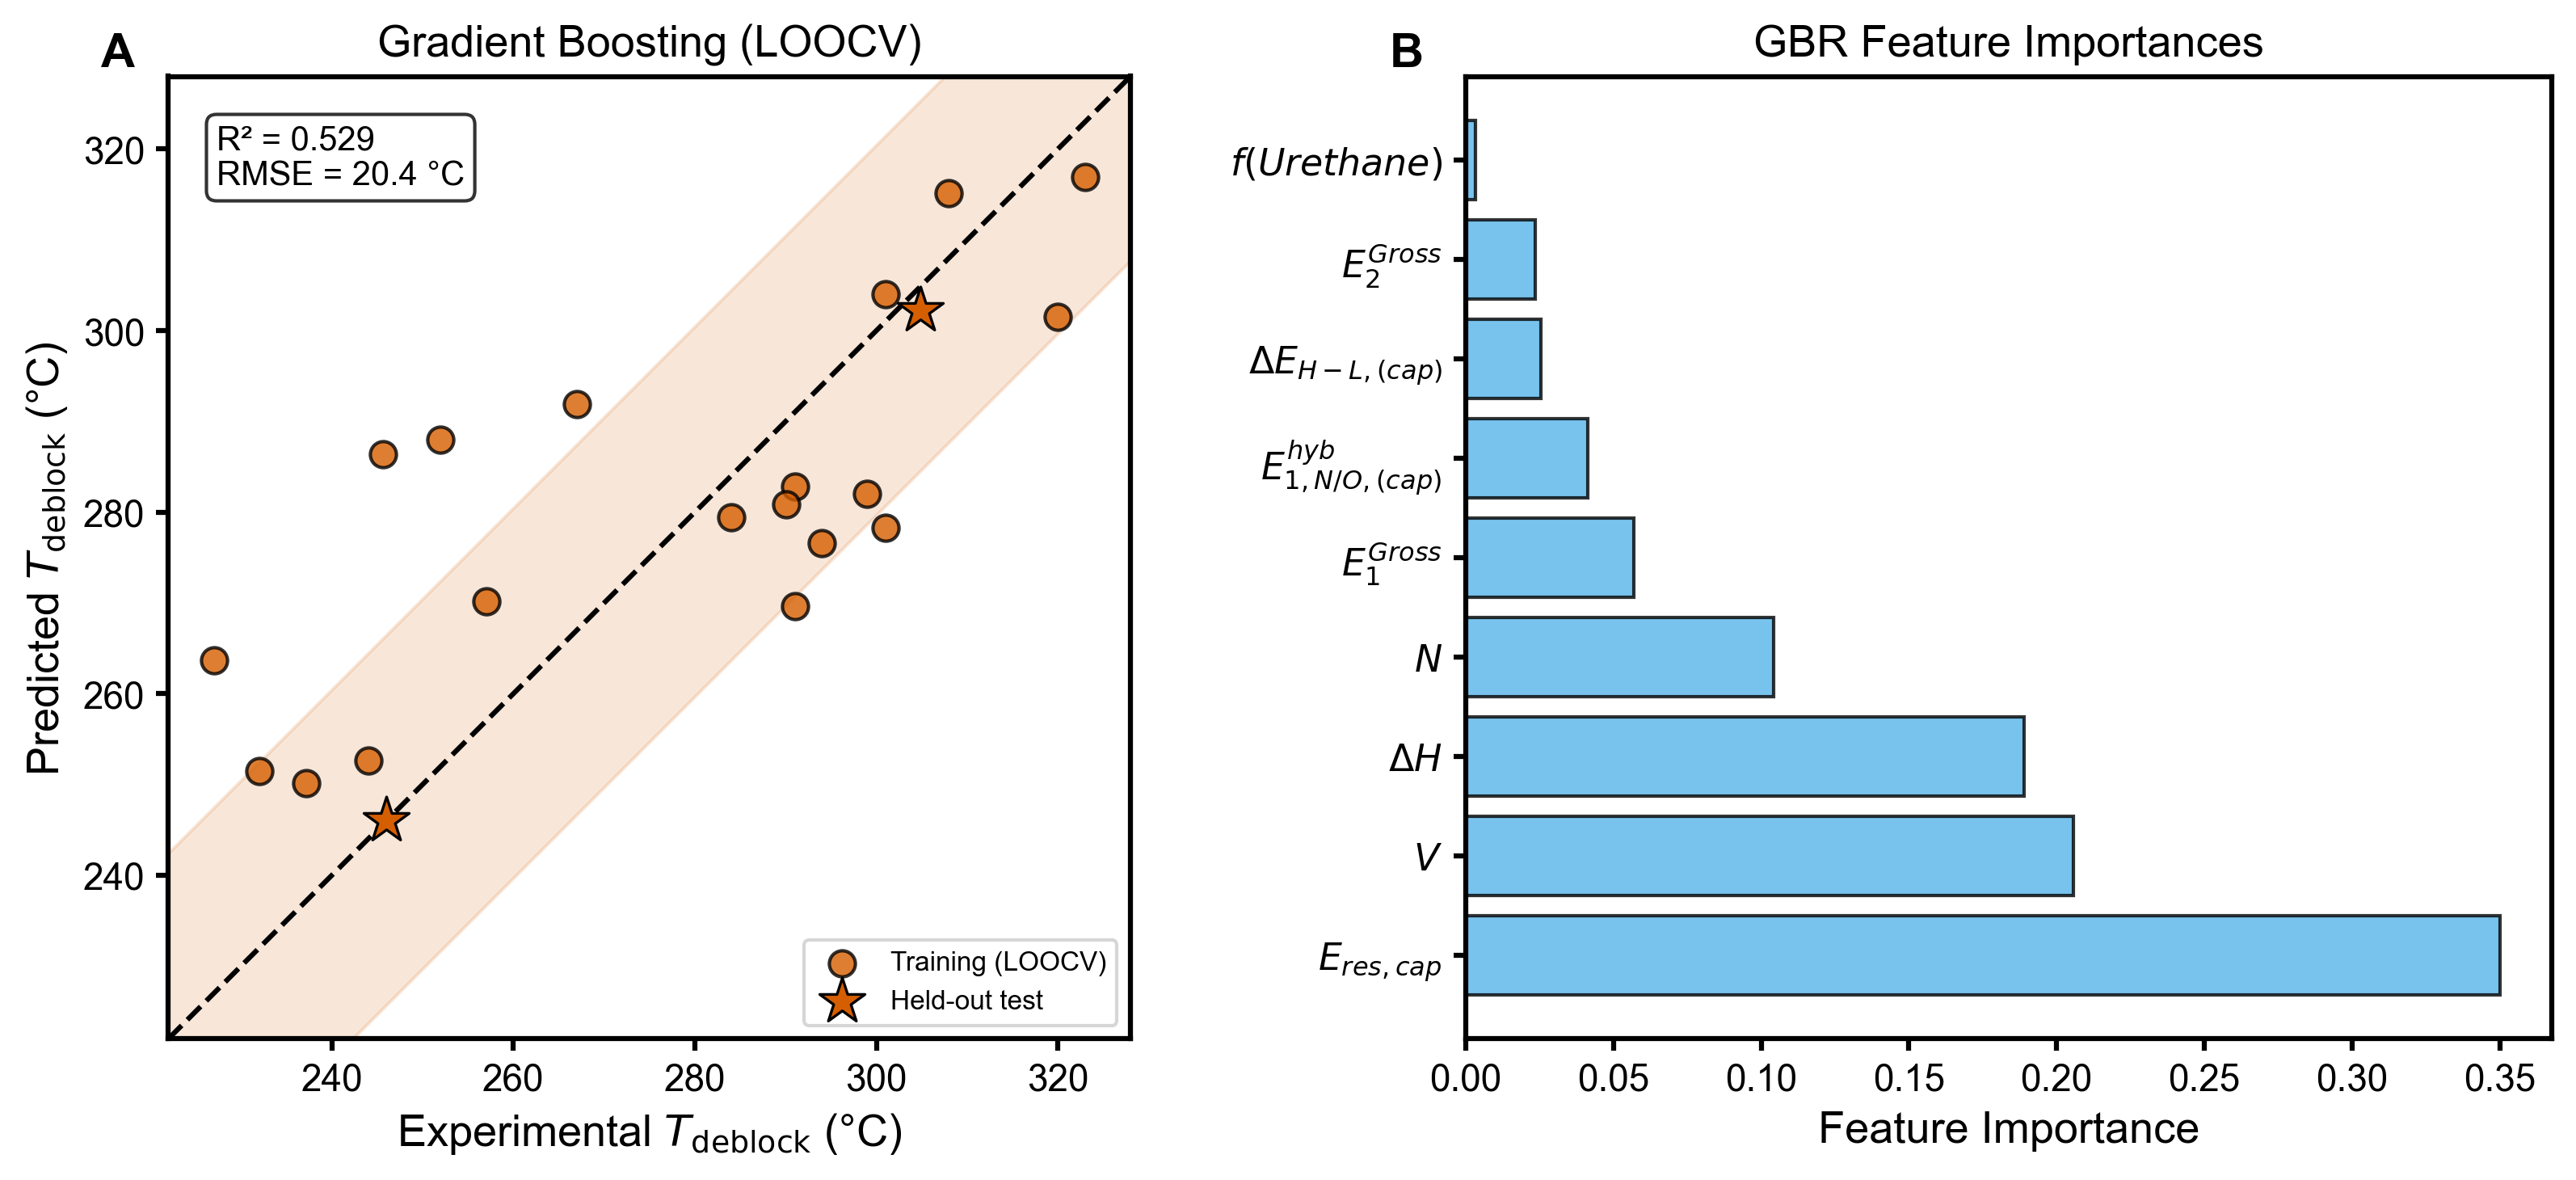

In [23]:
# Parity plot and tree-based feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), dpi=300)

plot_parity(y_train, y_pred_gbr, gbr_metrics['rmse'], gbr_metrics['r2'],
            'Gradient Boosting (LOOCV)', color='#D55E00', ax=ax1,
            y_test_true=y_test, y_test_pred=y_test_pred_gbr)

plot_feature_importance(gbr_model.feature_importances_, FEATURE_LABELS,
                        'GBR Feature Importances', ylabel='Feature Importance', ax=ax2)

# Add panel labels
ax1.text(-0.07, 1.00, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')
ax2.text(-0.07, 1.00, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.show()

## 15. Model Comparison — LOOCV Performance <a id="part2-7"></a>

All four models with the 9-feature BEBOP descriptor set, ranked by RMSE. Four-panel parity plot uses shared axes for direct comparison.

In [24]:
# Section 15: LOOCV performance table (with BEBOP), ranked by RMSE
comparison_df = pd.DataFrame({
    'Model': ['LASSO', 'Random Forest', 'Gaussian Process', 'Gradient Boosting'],
    'RMSE (°C)': [lasso_metrics['rmse'], rf_metrics['rmse'],
                  gpr_metrics['rmse'], gbr_metrics['rmse']],
    'R²': [lasso_metrics['r2'], rf_metrics['r2'],
           gpr_metrics['r2'], gbr_metrics['r2']]
}).sort_values('RMSE (°C)')

print("=" * 60)
print("MODEL COMPARISON — LOOCV Performance (With BEBOP)")
print("=" * 60)
display(comparison_df.style.format({'RMSE (°C)': '{:.2f}', 'R²': '{:.3f}'}).hide(axis='index'))

MODEL COMPARISON — LOOCV Performance (With BEBOP)


Model,RMSE (°C),R²
LASSO,11.71,0.845
Gaussian Process,16.38,0.696
Gradient Boosting,20.38,0.529
Random Forest,24.88,0.299


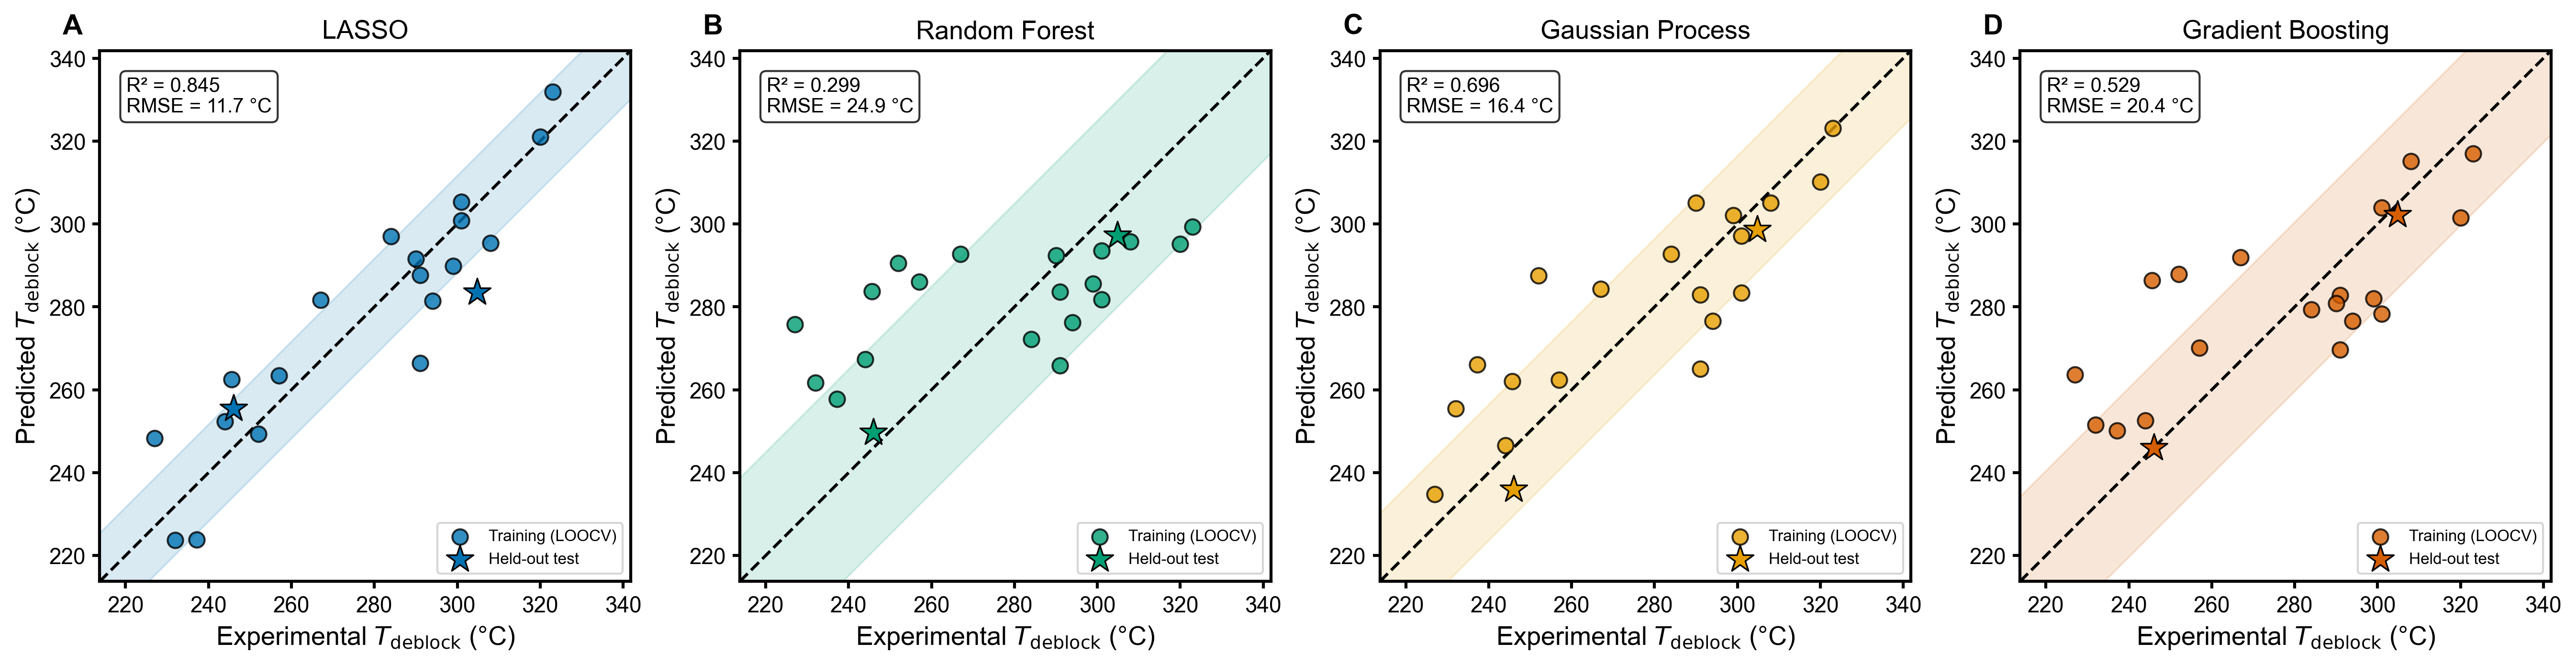

In [25]:
# Four-panel parity comparison (shared axis range for direct comparison)
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5), dpi=300)

all_models = [
    ('LASSO', y_pred_lasso, lasso_metrics, '#0072B2', y_test_pred_lasso),
    ('Random Forest', y_pred_rf, rf_metrics, '#009E73', y_test_pred_rf),
    ('Gaussian Process', y_pred_gpr, gpr_metrics, '#E69F00', y_test_pred_gpr),
    ('Gradient Boosting', y_pred_gbr, gbr_metrics, '#D55E00', y_test_pred_gbr)
]

# Shared axis range across all models
all_vals = np.concatenate([y_train, y_test] +
                          [y_pred_lasso, y_pred_rf, y_pred_gpr, y_pred_gbr,
                           y_test_pred_lasso, y_test_pred_rf, y_test_pred_gpr, y_test_pred_gbr])
shared_lims = (all_vals.min() - 10, all_vals.max() + 10)

for ax, (name, y_pred, metrics, color, y_tp) in zip(axes, all_models):
    plot_parity(y_train, y_pred, metrics['rmse'], metrics['r2'], name, color=color, ax=ax,
                y_test_true=y_test, y_test_pred=y_tp, lims=shared_lims)

# Add panel labels
for i, label in enumerate(['A', 'B', 'C', 'D']):
    axes[i].text(-0.07, 1.02, label, transform=axes[i].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.show()

## 16. BEBOP vs Non-BEBOP Comparison <a id="part2-8"></a>

All four models retrained with only 5 non-BEBOP features. The $2 \times 4$ parity grid and summary table report $\Delta\mathrm{RMSE}$ and $\Delta R^2$ with effective parameter counts.

In [26]:
# =============================================================================
# Section 16: Retrain RF, GPR, GBR without BEBOP descriptors
# LASSO without BEBOP was already trained in Section 3.2
# =============================================================================
print("=" * 60)
print("TRAINING ALL MODELS WITHOUT BEBOP DESCRIPTORS")
print("=" * 60)

# --- RF without BEBOP ---
print("\n[1/3] Random Forest...")
y_pred_rf_nb = run_loocv(X_train_no_bebop_scaled, y_train_no_bebop,
                          RandomForestRegressor, rf_params)
rf_metrics_nb = evaluate_model(y_train_no_bebop, y_pred_rf_nb, "  RF (no BEBOP)")
rf_model_nb = RandomForestRegressor(**rf_params)
rf_model_nb.fit(X_train_no_bebop_scaled, y_train_no_bebop)
y_test_pred_rf_nb = rf_model_nb.predict(X_test_no_bebop_scaled)

print("  Computing GDF...")
n_params_rf_nb = compute_gdf(RandomForestRegressor, rf_params,
                              X_train_no_bebop_scaled, y_train_no_bebop)
print(f"  Effective parameters (GDF): {n_params_rf_nb:.1f}")

# --- GPR without BEBOP ---
print("[2/3] Gaussian Process...")
n_feat_nb = X_train_no_bebop_scaled.shape[1]
loo = LeaveOneOut()
y_pred_gpr_nb = np.zeros_like(y_train_no_bebop)
for train_idx, test_idx in loo.split(X_train_no_bebop_scaled):
    kernel_nb = (ConstantKernel(1.0, (1e-3, 1e3)) *
                 RBF(np.ones(n_feat_nb), (1e-1, 10)) +
                 WhiteKernel(1.0, (1e-3, 10)))
    gpr_nb = GaussianProcessRegressor(kernel=kernel_nb, alpha=0.0, normalize_y=True,
                                       n_restarts_optimizer=3, random_state=RANDOM_STATE)
    gpr_nb.fit(X_train_no_bebop_scaled[train_idx], y_train_no_bebop[train_idx])
    y_pred_gpr_nb[test_idx] = gpr_nb.predict(X_train_no_bebop_scaled[test_idx])
gpr_metrics_nb = evaluate_model(y_train_no_bebop, y_pred_gpr_nb, "  GPR (no BEBOP)")
kernel_nb_final = (ConstantKernel(1.0, (1e-3, 1e3)) *
                   RBF(np.ones(n_feat_nb), (1e-1, 10)) +
                   WhiteKernel(1.0, (1e-3, 10)))
gpr_model_nb = GaussianProcessRegressor(kernel=kernel_nb_final, alpha=0.0, normalize_y=True,
                                         n_restarts_optimizer=3, random_state=RANDOM_STATE)
gpr_model_nb.fit(X_train_no_bebop_scaled, y_train_no_bebop)
y_test_pred_gpr_nb = gpr_model_nb.predict(X_test_no_bebop_scaled)

n_params_gpr_nb = compute_gpr_hat_trace(gpr_model_nb, X_train_no_bebop_scaled)
print(f"  Effective parameters (hat trace): {n_params_gpr_nb:.2f}")

# --- GBR without BEBOP ---
print("[3/3] Gradient Boosting...")
y_pred_gbr_nb = run_loocv(X_train_no_bebop_scaled, y_train_no_bebop,
                            GradientBoostingRegressor, gbr_params)
gbr_metrics_nb = evaluate_model(y_train_no_bebop, y_pred_gbr_nb, "  GBR (no BEBOP)")
gbr_model_nb = GradientBoostingRegressor(**gbr_params)
gbr_model_nb.fit(X_train_no_bebop_scaled, y_train_no_bebop)
y_test_pred_gbr_nb = gbr_model_nb.predict(X_test_no_bebop_scaled)

print("  Computing GDF...")
n_params_gbr_nb = compute_gdf(GradientBoostingRegressor, gbr_params,
                                X_train_no_bebop_scaled, y_train_no_bebop)
print(f"  Effective parameters (GDF): {n_params_gbr_nb:.1f}")

# LASSO without BEBOP test predictions
y_test_pred_lasso_nb = lasso_final_no_bebop.predict(X_test_no_bebop_scaled)

TRAINING ALL MODELS WITHOUT BEBOP DESCRIPTORS

[1/3] Random Forest...
  RF (no BEBOP): RMSE = 30.63 °C | R² = -0.063
  Computing GDF...
  Effective parameters (GDF): 12.2
[2/3] Gaussian Process...
  GPR (no BEBOP): RMSE = 30.73 °C | R² = -0.070
  Effective parameters (hat trace): 13.78
[3/3] Gradient Boosting...
  GBR (no BEBOP): RMSE = 36.78 °C | R² = -0.532
  Computing GDF...
  Effective parameters (GDF): 15.9


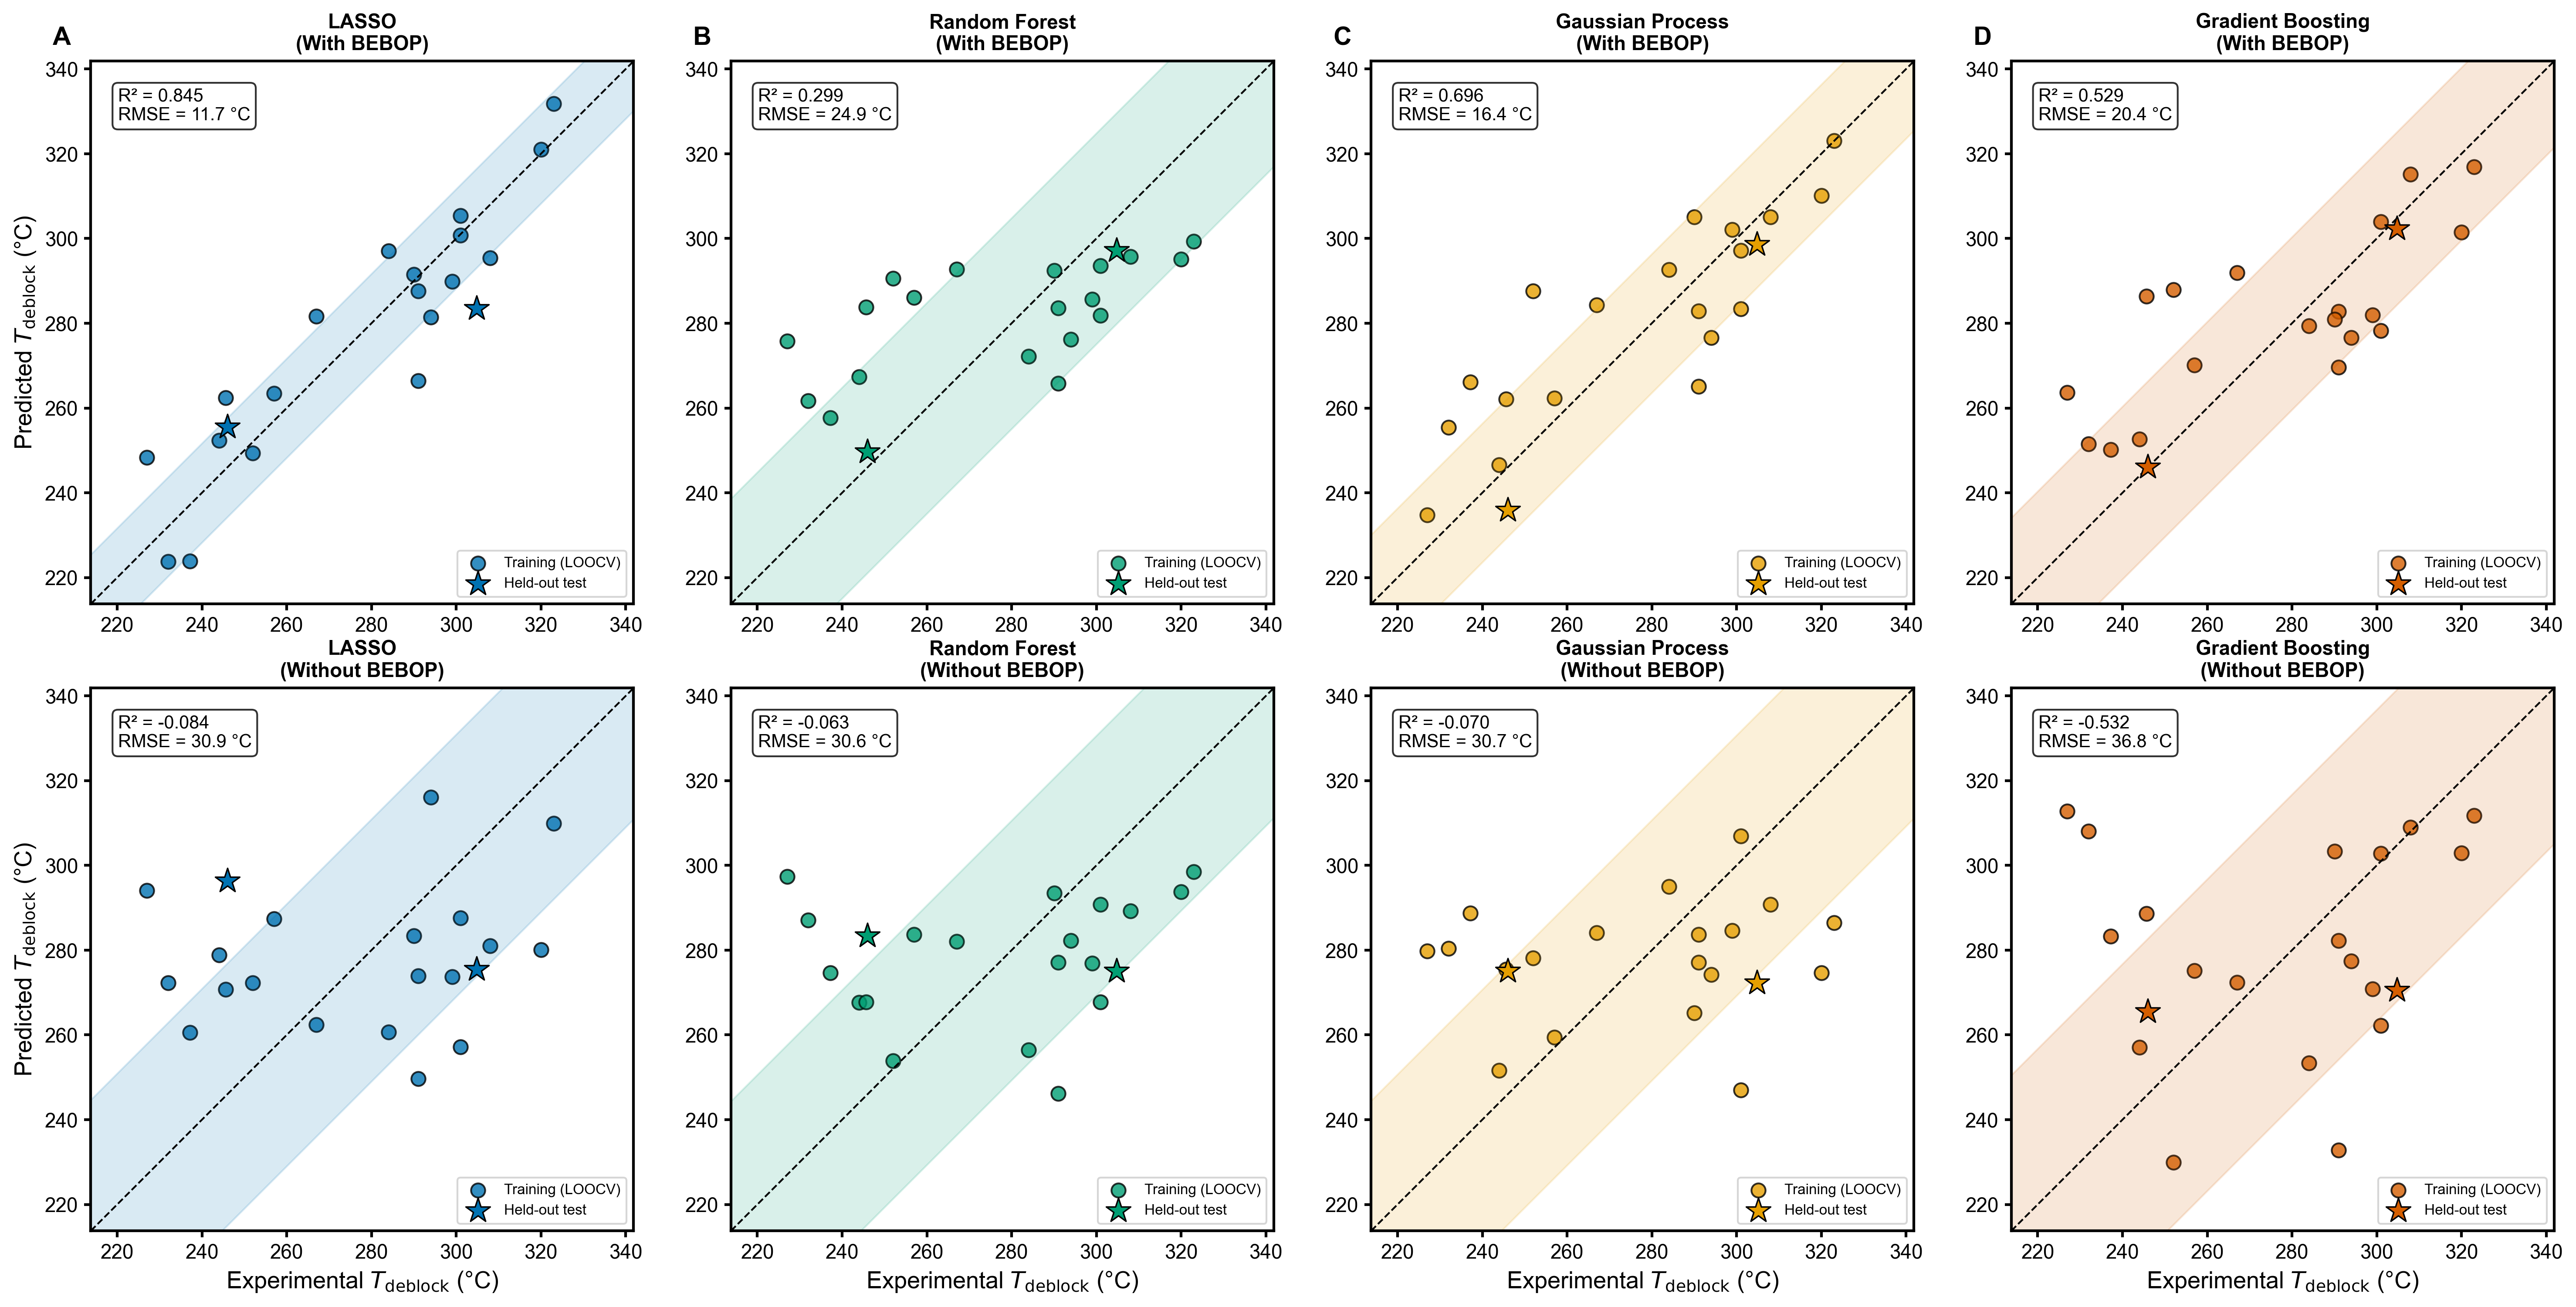

Figure saved as:
  - parity_bebop_comparison_all_models.png
  - parity_bebop_comparison_all_models.pdf


In [27]:
# 2×4 parity grid: BEBOP (top row) vs non-BEBOP (bottom row)
# Shared axis limits across all 8 panels for direct visual comparison
fig, axes = plt.subplots(2, 4, figsize=(20, 10), dpi=300)

models_bebop = [
    ('LASSO', y_pred_lasso, lasso_metrics, '#0072B2', y_test_pred_lasso),
    ('Random Forest', y_pred_rf, rf_metrics, '#009E73', y_test_pred_rf),
    ('Gaussian Process', y_pred_gpr, gpr_metrics, '#E69F00', y_test_pred_gpr),
    ('Gradient Boosting', y_pred_gbr, gbr_metrics, '#D55E00', y_test_pred_gbr)
]

models_no_bebop = [
    ('LASSO', y_pred_lasso_no_bebop, lasso_metrics_no_bebop, '#0072B2', y_test_pred_lasso_nb),
    ('Random Forest', y_pred_rf_nb, rf_metrics_nb, '#009E73', y_test_pred_rf_nb),
    ('Gaussian Process', y_pred_gpr_nb, gpr_metrics_nb, '#E69F00', y_test_pred_gpr_nb),
    ('Gradient Boosting', y_pred_gbr_nb, gbr_metrics_nb, '#D55E00', y_test_pred_gbr_nb)
]

all_vals = np.concatenate([
    y_train, y_train_no_bebop, y_test,
    y_pred_lasso, y_pred_rf, y_pred_gpr, y_pred_gbr,
    y_test_pred_lasso, y_test_pred_rf, y_test_pred_gpr, y_test_pred_gbr,
    y_pred_lasso_no_bebop, y_pred_rf_nb, y_pred_gpr_nb, y_pred_gbr_nb,
    y_test_pred_lasso_nb, y_test_pred_rf_nb, y_test_pred_gpr_nb, y_test_pred_gbr_nb
])
lims = [all_vals.min() - 10, all_vals.max() + 10]

# Top row: WITH BEBOP
for col, (name, y_pred, metrics, color, y_tp) in enumerate(models_bebop):
    ax = axes[0, col]
    ax.scatter(y_train, y_pred, c=color, edgecolor='k', alpha=0.8, s=60,
               label='Training (LOOCV)')
    ax.scatter(y_test, y_tp, marker='*', c=color, edgecolor='k', s=200,
               linewidths=0.8, zorder=4, label='Held-out test')
    ax.plot(lims, lims, 'k--', lw=1)
    ax.fill_between(lims, [lims[0]-metrics['rmse'], lims[1]-metrics['rmse']],
                    [lims[0]+metrics['rmse'], lims[1]+metrics['rmse']], color=color, alpha=0.15)
    ax.text(0.05, 0.95, f"R² = {metrics['r2']:.3f}\nRMSE = {metrics['rmse']:.1f} °C",
            transform=ax.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_xlim(lims); ax.set_ylim(lims); ax.set_aspect('equal')
    ax.set_title(f'{name}\n(With BEBOP)', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    if col == 0:
        ax.set_ylabel(r'Predicted $T_{\mathrm{deblock}}$ (°C)')

# Bottom row: WITHOUT BEBOP
for col, (name, y_pred, metrics, color, y_tp) in enumerate(models_no_bebop):
    ax = axes[1, col]
    ax.scatter(y_train_no_bebop, y_pred, c=color, edgecolor='k', alpha=0.8, s=60,
               label='Training (LOOCV)')
    ax.scatter(y_test, y_tp, marker='*', c=color, edgecolor='k', s=200,
               linewidths=0.8, zorder=4, label='Held-out test')
    ax.plot(lims, lims, 'k--', lw=1)
    ax.fill_between(lims, [lims[0]-metrics['rmse'], lims[1]-metrics['rmse']],
                    [lims[0]+metrics['rmse'], lims[1]+metrics['rmse']], color=color, alpha=0.15)
    ax.text(0.05, 0.95, f"R² = {metrics['r2']:.3f}\nRMSE = {metrics['rmse']:.1f} °C",
            transform=ax.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_xlim(lims); ax.set_ylim(lims); ax.set_aspect('equal')
    ax.set_title(f'{name}\n(Without BEBOP)', fontsize=11, fontweight='bold')
    ax.set_xlabel(r'Experimental $T_{\mathrm{deblock}}$ (°C)')
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    if col == 0:
        ax.set_ylabel(r'Predicted $T_{\mathrm{deblock}}$ (°C)')

# Add panel labels (A, B, C, D) for top row only
for j, label in enumerate(['A', 'B', 'C', 'D']):
    axes[0, j].text(-0.07, 1.02, label, transform=axes[0, j].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()

# Save in both PNG and PDF formats
plt.savefig('parity_bebop_comparison_all_models.png', dpi=FIG_DPI, bbox_inches='tight')
plt.savefig('parity_bebop_comparison_all_models.pdf', dpi=FIG_DPI, bbox_inches='tight')

plt.show()

print("Figure saved as:")
print("  - parity_bebop_comparison_all_models.png")
print("  - parity_bebop_comparison_all_models.pdf")

In [28]:
# BEBOP vs non-BEBOP summary with effective parameter counts and Δ metrics
print("=" * 60)
print("BEBOP vs NON-BEBOP PERFORMANCE COMPARISON")
print("=" * 60)

bebop_comparison = pd.DataFrame({
    'Model': ['LASSO', 'Random Forest', 'Gaussian Process', 'Gradient Boosting'],
    'Params (BEBOP)': [n_params_lasso, n_params_rf, n_params_gpr, n_params_gbr],
    'RMSE w/ BEBOP': [lasso_metrics['rmse'], rf_metrics['rmse'],
                      gpr_metrics['rmse'], gbr_metrics['rmse']],
    'R² w/ BEBOP':   [lasso_metrics['r2'], rf_metrics['r2'],
                      gpr_metrics['r2'], gbr_metrics['r2']],
    'Params (no BEBOP)': [n_params_lasso_nb, n_params_rf_nb, n_params_gpr_nb, n_params_gbr_nb],
    'RMSE w/o BEBOP': [lasso_metrics_no_bebop['rmse'], rf_metrics_nb['rmse'],
                       gpr_metrics_nb['rmse'], gbr_metrics_nb['rmse']],
    'R² w/o BEBOP':   [lasso_metrics_no_bebop['r2'], rf_metrics_nb['r2'],
                       gpr_metrics_nb['r2'], gbr_metrics_nb['r2']]
})

bebop_comparison['ΔRMSE'] = bebop_comparison['RMSE w/o BEBOP'] - bebop_comparison['RMSE w/ BEBOP']
bebop_comparison['ΔR²'] = bebop_comparison['R² w/ BEBOP'] - bebop_comparison['R² w/o BEBOP']

display(bebop_comparison.style.format({
    'Params (BEBOP)': '{:,}', 'Params (no BEBOP)': '{:,}',
    'RMSE w/ BEBOP': '{:.2f}', 'R² w/ BEBOP': '{:.3f}',
    'RMSE w/o BEBOP': '{:.2f}', 'R² w/o BEBOP': '{:.3f}',
    'ΔRMSE': '{:+.2f}', 'ΔR²': '{:+.3f}'
}).hide(axis='index'))

BEBOP vs NON-BEBOP PERFORMANCE COMPARISON


Model,Params (BEBOP),RMSE w/ BEBOP,R² w/ BEBOP,Params (no BEBOP),RMSE w/o BEBOP,R² w/o BEBOP,ΔRMSE,ΔR²
LASSO,9.0,11.71,0.845,5.0,30.94,-0.084,+19.23,+0.929
Random Forest,12.194000003205474,24.88,0.299,12.194000003887595,30.63,-0.063,+5.75,+0.362
Gaussian Process,13.470052066624403,16.38,0.696,13.783884571843297,30.73,-0.070,+14.34,+0.766
Gradient Boosting,24.524591562766318,20.38,0.529,15.89955101292162,36.78,-0.532,+16.39,+1.062


## 17. Model Complexity — AIC/BIC Analysis <a id="part2-9"></a>

Assess overfitting using information criteria:

$$\text{AIC} = n \ln\!\left(\frac{\text{RSS}}{n}\right) + 2k, \qquad \text{BIC} = n \ln\!\left(\frac{\text{RSS}}{n}\right) + k \ln(n)$$

where $n = 19$, RSS is the residual sum of squares from LOOCV, and $k$ is the effective number of parameters.

$\Delta = \text{(with BEBOP)} - \text{(without BEBOP)}$: negative values indicate BEBOP is justified; $|\Delta| < 2$ is inconclusive, $2 \leq |\Delta| < 10$ is positive evidence, $|\Delta| \geq 10$ is strong evidence. BIC penalizes complexity more heavily than AIC ($\ln(n)/2 \approx 1.5$ for $n=19$).

### Effective Parameter Estimation Methodology

The information-theoretic model comparison in this section (AIC, BIC) requires a consistent measure of model complexity $k$ across fundamentally different model families. Naïve parameter counting (e.g., total leaf nodes for tree ensembles) is not appropriate for comparing linear models, kernel methods, and ensemble learners on equal footing. We adopt principled estimators of **effective degrees of freedom** ($\mathrm{df}_{\mathrm{eff}}$) tailored to each model class:

**LASSO Regression.** The effective parameter count equals the number of non-zero coefficients plus the intercept. This is exact for $L_1$-penalized linear regression (Zou, Hastie, & Tibshirani, 2007).

**Gaussian Process Regression.** We compute $\mathrm{df}_{\mathrm{eff}}$ as the trace of the smoother (hat) matrix:

$$\mathrm{df}_{\mathrm{eff}} = \mathrm{tr}\!\left[\mathbf{K}_{\mathrm{signal}}\left(\mathbf{K}_{\mathrm{signal}} + \sigma_n^2\,\mathbf{I}\right)^{-1}\right]$$

where $\mathbf{K}_{\mathrm{signal}}$ is the signal covariance matrix (excluding observation noise) and $\sigma_n^2$ is the learned noise variance from the `WhiteKernel`. This is the standard complexity measure for kernel smoothers (Rasmussen & Williams, *Gaussian Processes for Machine Learning*, MIT Press, 2006, §5.4.1). The trace satisfies $0 \leq \mathrm{df}_{\mathrm{eff}} \leq n$ and captures how the kernel's smoothness constrains the model's flexibility.

**Random Forest and Gradient Boosting.** We employ the **Generalized Degrees of Freedom** (GDF) estimator of Ye (1998):

$$\mathrm{GDF} = \sum_{i=1}^{n} \frac{\partial\,\hat{y}_i}{\partial\,y_i}$$

approximated by finite differences. Each training response $y_i$ is perturbed by a small amount $\varepsilon$, the model is refit, and the sensitivity of the prediction at index $i$ is recorded. The GDF is well-defined for arbitrary prediction procedures, including tree ensembles, and naturally accounts for regularization effects such as bootstrap aggregation (RF) and learning-rate shrinkage (GBR).

**Reference:** J. Ye, "On Measuring and Correcting the Effects of Data Mining and Model Selection," *J. Am. Stat. Assoc.* **93**, 120–131 (1998). DOI: [10.1080/01621459.1998.10474094](https://doi.org/10.1080/01621459.1998.10474094)

---

In [29]:
# =============================================================================
# Section 17: AIC/BIC Analysis Using Parameters from Section 16
# =============================================================================

def calculate_aic_bic(residuals, n_params, n_samples):
    """
    Calculate AIC and BIC for regression model.
    
    Parameters:
    -----------
    residuals : array-like
        LOOCV residuals (y_true - y_pred)
    n_params : int
        Number of effective parameters
    n_samples : int  
        Number of observations (19 for LOOCV training)
    
    Returns:
    --------
    aic, bic : float
    """
    rss = np.sum(residuals**2)  # Residual sum of squares
    
    if rss <= 0:
        return np.inf, np.inf
    
    # AIC = n*ln(RSS/n) + 2k
    aic = n_samples * np.log(rss / n_samples) + 2 * n_params
    
    # BIC = n*ln(RSS/n) + k*ln(n)  
    bic = n_samples * np.log(rss / n_samples) + n_params * np.log(n_samples)
    
    return aic, bic

# Number of training samples
n_train = len(y_train)

# Get LOOCV residuals using correct variable names
# WITH BEBOP models
residuals_lasso_bebop = y_train - y_pred_lasso
residuals_rf_bebop = y_train - y_pred_rf
residuals_gpr_bebop = y_train - y_pred_gpr
residuals_gbr_bebop = y_train - y_pred_gbr

# WITHOUT BEBOP models
residuals_lasso_no_bebop = y_train_no_bebop - y_pred_lasso_no_bebop
residuals_rf_no_bebop = y_train_no_bebop - y_pred_rf_nb
residuals_gpr_no_bebop = y_train_no_bebop - y_pred_gpr_nb
residuals_gbr_no_bebop = y_train_no_bebop - y_pred_gbr_nb

# Calculate AIC/BIC using parameter counts from earlier sections
# WITH BEBOP (uses n_params_lasso, n_params_rf, n_params_gpr, n_params_gbr)
aic_lasso_bebop, bic_lasso_bebop = calculate_aic_bic(residuals_lasso_bebop, n_params_lasso, n_train)
aic_rf_bebop, bic_rf_bebop = calculate_aic_bic(residuals_rf_bebop, n_params_rf, n_train)
aic_gpr_bebop, bic_gpr_bebop = calculate_aic_bic(residuals_gpr_bebop, n_params_gpr, n_train)
aic_gbr_bebop, bic_gbr_bebop = calculate_aic_bic(residuals_gbr_bebop, n_params_gbr, n_train)

# WITHOUT BEBOP (uses n_params_lasso_nb, n_params_rf_nb, n_params_gpr_nb, n_params_gbr_nb)
aic_lasso_no_bebop, bic_lasso_no_bebop = calculate_aic_bic(residuals_lasso_no_bebop, n_params_lasso_nb, len(y_train_no_bebop))
aic_rf_no_bebop, bic_rf_no_bebop = calculate_aic_bic(residuals_rf_no_bebop, n_params_rf_nb, len(y_train_no_bebop))
aic_gpr_no_bebop, bic_gpr_no_bebop = calculate_aic_bic(residuals_gpr_no_bebop, n_params_gpr_nb, len(y_train_no_bebop))
aic_gbr_no_bebop, bic_gbr_no_bebop = calculate_aic_bic(residuals_gbr_no_bebop, n_params_gbr_nb, len(y_train_no_bebop))

# ===== CREATE COMPREHENSIVE AIC/BIC TABLE =====

print("=" * 90)
print("MODEL COMPLEXITY ANALYSIS — AIC AND BIC")
print("=" * 90)

aic_bic_df = pd.DataFrame({
    'Model': ['LASSO', 'Random Forest', 'Gaussian Process', 'Gradient Boosting'],
    'k (w/ BEBOP)': [n_params_lasso, n_params_rf, n_params_gpr, n_params_gbr],
    'k (w/o BEBOP)': [n_params_lasso_nb, n_params_rf_nb, n_params_gpr_nb, n_params_gbr_nb],
    'RMSE (w/ BEBOP)': [lasso_metrics['rmse'], rf_metrics['rmse'], gpr_metrics['rmse'], gbr_metrics['rmse']],
    'RMSE (w/o BEBOP)': [lasso_metrics_no_bebop['rmse'], rf_metrics_nb['rmse'], 
                         gpr_metrics_nb['rmse'], gbr_metrics_nb['rmse']],
    'AIC (w/ BEBOP)': [aic_lasso_bebop, aic_rf_bebop, aic_gpr_bebop, aic_gbr_bebop],
    'AIC (w/o BEBOP)': [aic_lasso_no_bebop, aic_rf_no_bebop, aic_gpr_no_bebop, aic_gbr_no_bebop],
    'BIC (w/ BEBOP)': [bic_lasso_bebop, bic_rf_bebop, bic_gpr_bebop, bic_gbr_bebop],
    'BIC (w/o BEBOP)': [bic_lasso_no_bebop, bic_rf_no_bebop, bic_gpr_no_bebop, bic_gbr_no_bebop]
})

# Calculate deltas
aic_bic_df['ΔAIC'] = aic_bic_df['AIC (w/ BEBOP)'] - aic_bic_df['AIC (w/o BEBOP)']
aic_bic_df['ΔBIC'] = aic_bic_df['BIC (w/ BEBOP)'] - aic_bic_df['BIC (w/o BEBOP)']

print("\n--- Complete AIC/BIC Comparison ---\n")
print("Note: k = effective degrees of freedom (see methodology note above)")
print("      LASSO: non-zero coefficients + intercept")
print("      GPR: hat matrix trace (Rasmussen & Williams, 2006)")
print("      RF/GBR: Generalized Degrees of Freedom (Ye, 1998)\n")

display(aic_bic_df.style.format({
    'k (w/ BEBOP)': '{:,.0f}',
    'k (w/o BEBOP)': '{:,.0f}',
    'RMSE (w/ BEBOP)': '{:.2f}',
    'RMSE (w/o BEBOP)': '{:.2f}',
    'AIC (w/ BEBOP)': '{:.1f}',
    'AIC (w/o BEBOP)': '{:.1f}',
    'BIC (w/ BEBOP)': '{:.1f}',
    'BIC (w/o BEBOP)': '{:.1f}',
    'ΔAIC': '{:+.1f}',
    'ΔBIC': '{:+.1f}'
}).hide(axis='index'))

# ===== INTERPRETATION =====

print("\n" + "=" * 90)
print("OVERFITTING ASSESSMENT")
print("=" * 90)
print("\nΔAIC/ΔBIC = (with BEBOP) − (without BEBOP)")
print("Negative values → BEBOP improves model quality (NOT overfitting)")
print("Positive values → BEBOP adds complexity without benefit (potential overfitting)\n")

for i, row in aic_bic_df.iterrows():
    model = row['Model']
    delta_aic = row['ΔAIC']
    delta_bic = row['ΔBIC']
    k_with = row['k (w/ BEBOP)']
    k_without = row['k (w/o BEBOP)']
    
    print(f"\n{model}:")
    print(f"  Parameters: {k_without:,.0f} (no BEBOP) → {k_with:,.0f} (with BEBOP)")
    
    # AIC interpretation
    print(f"  ΔAIC = {delta_aic:+7.1f}", end="  ")
    if delta_aic < -10:
        aic_verdict = "STRONGLY supports BEBOP"
    elif delta_aic < -2:
        aic_verdict = "Supports BEBOP"
    elif delta_aic > 10:
        aic_verdict = "STRONG overfitting concern"
    elif delta_aic > 2:
        aic_verdict = "Overfitting risk"
    else:
        aic_verdict = "Weak evidence"
    print(f" → {aic_verdict}")
    
    # BIC interpretation (more conservative)
    print(f"  ΔBIC = {delta_bic:+7.1f}", end="  ")
    if delta_bic < -10:
        bic_verdict = "STRONGLY supports BEBOP (NO overfitting)"
    elif delta_bic < -2:
        bic_verdict = "Supports BEBOP (NO overfitting)"
    elif delta_bic > 10:
        bic_verdict = "SEVERE overfitting concern"
    elif delta_bic > 2:
        bic_verdict = "Overfitting risk"
    else:
        bic_verdict = "Borderline"
    print(f" → {bic_verdict}")

# ===== SUMMARY VERDICT =====

bebop_justified_aic = sum(1 for x in aic_bic_df['ΔAIC'] if x < -2)
bebop_justified_bic = sum(1 for x in aic_bic_df['ΔBIC'] if x < -2)
overfitting_bic = sum(1 for x in aic_bic_df['ΔBIC'] if x > 2)

print("\n" + "=" * 90)
print("SUMMARY VERDICT")
print("=" * 90)
print(f"\nModels where BEBOP is justified by AIC (ΔAIC < −2): {bebop_justified_aic}/4")
print(f"Models where BEBOP is justified by BIC (ΔBIC < −2): {bebop_justified_bic}/4")
print(f"Models with overfitting concern (ΔBIC > +2):        {overfitting_bic}/4")

print("\n" + "─" * 90)

if bebop_justified_bic >= 3:
    print("\n✓ CONCLUSION: BEBOP descriptors improve predictive accuracy for the majority of models.")
    print("  The added model complexity is justified by substantially improved fit in")
    print(f"  {bebop_justified_bic}/4 models (by BIC) and {bebop_justified_aic}/4 models (by AIC).")
    if overfitting_bic > 0:
        flagged = [row['Model'] for _, row in aic_bic_df.iterrows() if row['ΔBIC'] > 2]
        print(f"  Exception: {', '.join(flagged)} show(s) marginal overfitting risk by BIC (ΔBIC > +2),")
        print("  though AIC still supports BEBOP inclusion for all models.")
    print("  Recommendation: Use BEBOP-enhanced models for predictions.")
elif overfitting_bic >= 2:
    print("\n✗ CONCLUSION: Evidence of overfitting in BEBOP models.")
    print("  Added complexity does not provide sufficient predictive benefit.")
    print("  Recommendation: Use simpler non-BEBOP models or reduce feature set.")
else:
    print("\n~ CONCLUSION: Mixed evidence across models.")
    print("  Some models benefit from BEBOP, others show marginal improvement.")
    print("  Recommendation: Model-specific assessment — prioritize models with ΔBIC < −2.")

print("\nNote: BIC is more conservative than AIC (stronger complexity penalty).")
print("      For small samples (n=19), BIC is generally preferred to guard against overfitting.")
print("=" * 90)


MODEL COMPLEXITY ANALYSIS — AIC AND BIC

--- Complete AIC/BIC Comparison ---

Note: k = effective degrees of freedom (see methodology note above)
      LASSO: non-zero coefficients + intercept
      GPR: hat matrix trace (Rasmussen & Williams, 2006)
      RF/GBR: Generalized Degrees of Freedom (Ye, 1998)



Model,k (w/ BEBOP),k (w/o BEBOP),RMSE (w/ BEBOP),RMSE (w/o BEBOP),AIC (w/ BEBOP),AIC (w/o BEBOP),BIC (w/ BEBOP),BIC (w/o BEBOP),ΔAIC,ΔBIC
LASSO,9,5,11.71,30.94,111.5,140.4,120.0,145.1,-28.9,-25.1
Random Forest,12,12,24.88,30.63,146.5,154.4,158.0,165.9,-7.9,-7.9
Gaussian Process,13,14,16.38,30.73,133.2,157.7,145.9,170.7,-24.5,-24.8
Gradient Boosting,25,16,20.38,36.78,163.6,168.8,186.8,183.8,-5.2,+3.0



OVERFITTING ASSESSMENT

ΔAIC/ΔBIC = (with BEBOP) − (without BEBOP)
Negative values → BEBOP improves model quality (NOT overfitting)
Positive values → BEBOP adds complexity without benefit (potential overfitting)


LASSO:
  Parameters: 5 (no BEBOP) → 9 (with BEBOP)
  ΔAIC =   -28.9   → STRONGLY supports BEBOP
  ΔBIC =   -25.1   → STRONGLY supports BEBOP (NO overfitting)

Random Forest:
  Parameters: 12 (no BEBOP) → 12 (with BEBOP)
  ΔAIC =    -7.9   → Supports BEBOP
  ΔBIC =    -7.9   → Supports BEBOP (NO overfitting)

Gaussian Process:
  Parameters: 14 (no BEBOP) → 13 (with BEBOP)
  ΔAIC =   -24.5   → STRONGLY supports BEBOP
  ΔBIC =   -24.8   → STRONGLY supports BEBOP (NO overfitting)

Gradient Boosting:
  Parameters: 16 (no BEBOP) → 25 (with BEBOP)
  ΔAIC =    -5.2   → Supports BEBOP
  ΔBIC =    +3.0   → Overfitting risk

SUMMARY VERDICT

Models where BEBOP is justified by AIC (ΔAIC < −2): 4/4
Models where BEBOP is justified by BIC (ΔBIC < −2): 3/4
Models with overfitting concern (Δ

## 18. External Test Set Predictions <a id="part2-10"></a>

Predictions for the two held-out compounds (Octanone Oxime and 2-Hydroxyethylmethacrylate) using all four BEBOP-trained models. These compounds were excluded from all training, cross-validation, and hyperparameter selection.


In [30]:
# =============================================================================
# Section 18: External test set predictions (held-out compounds)
# These compounds were excluded from all training and LOOCV
# =============================================================================
print("=" * 60)
print("EXTERNAL TEST SET PREDICTIONS")
print("=" * 60)

test_df_clean = test_df.dropna(subset=FEATURE_COLS).copy()

if len(test_df_clean) == 0:
    print("\n[Warning] No valid test samples after removing NaN values.")
else:
    X_test = test_df_clean[FEATURE_COLS].to_numpy(dtype=float)
    X_test_scaled = scaler.transform(X_test)

    pred_lasso_test = lasso_final.predict(X_test_scaled)
    pred_rf = rf_model.predict(X_test_scaled)
    pred_gpr = gpr_model.predict(X_test_scaled)
    pred_gbr = gbr_model.predict(X_test_scaled)

    results = pd.DataFrame({
        ID_COL: test_df_clean[ID_COL].values,
        'Experimental (°C)': test_df_clean[TARGET_COL].values,
        'LASSO (°C)': pred_lasso_test,
        'RF (°C)': pred_rf,
        'GPR (°C)': pred_gpr,
        'GBR (°C)': pred_gbr
    })

    for model, pred in [('LASSO', pred_lasso_test), ('RF', pred_rf),
                        ('GPR', pred_gpr), ('GBR', pred_gbr)]:
        results[f'{model} Error'] = results['Experimental (°C)'] - pred

    print("\n--- Predictions for Held-Out Compounds ---")
    display(results.style.format(precision=2).hide(axis='index'))

EXTERNAL TEST SET PREDICTIONS

--- Predictions for Held-Out Compounds ---


Capping agent,Experimental (°C),LASSO (°C),RF (°C),GPR (°C),GBR (°C),LASSO Error,RF Error,GPR Error,GBR Error
Octanone Oxime,246.00,255.50,249.65,235.92,246.03,-9.50,-3.65,10.08,-0.03
2Hydroxyethylmethacrylate,304.80,283.48,297.21,298.64,302.26,21.32,7.59,6.16,2.54


## 19. Residual Analysis <a id="part2-11"></a>

Residual plots ($\text{Residual}_i = T_{\mathrm{deblock},i}^{\text{exp}} - T_{\mathrm{deblock},i}^{\text{pred}}$) for all 21 systems. The $2 \times 4$ layout compares BEBOP (top) vs. non-BEBOP (bottom) across all four models. Training compounds shown as circles, held-out test compounds as stars.

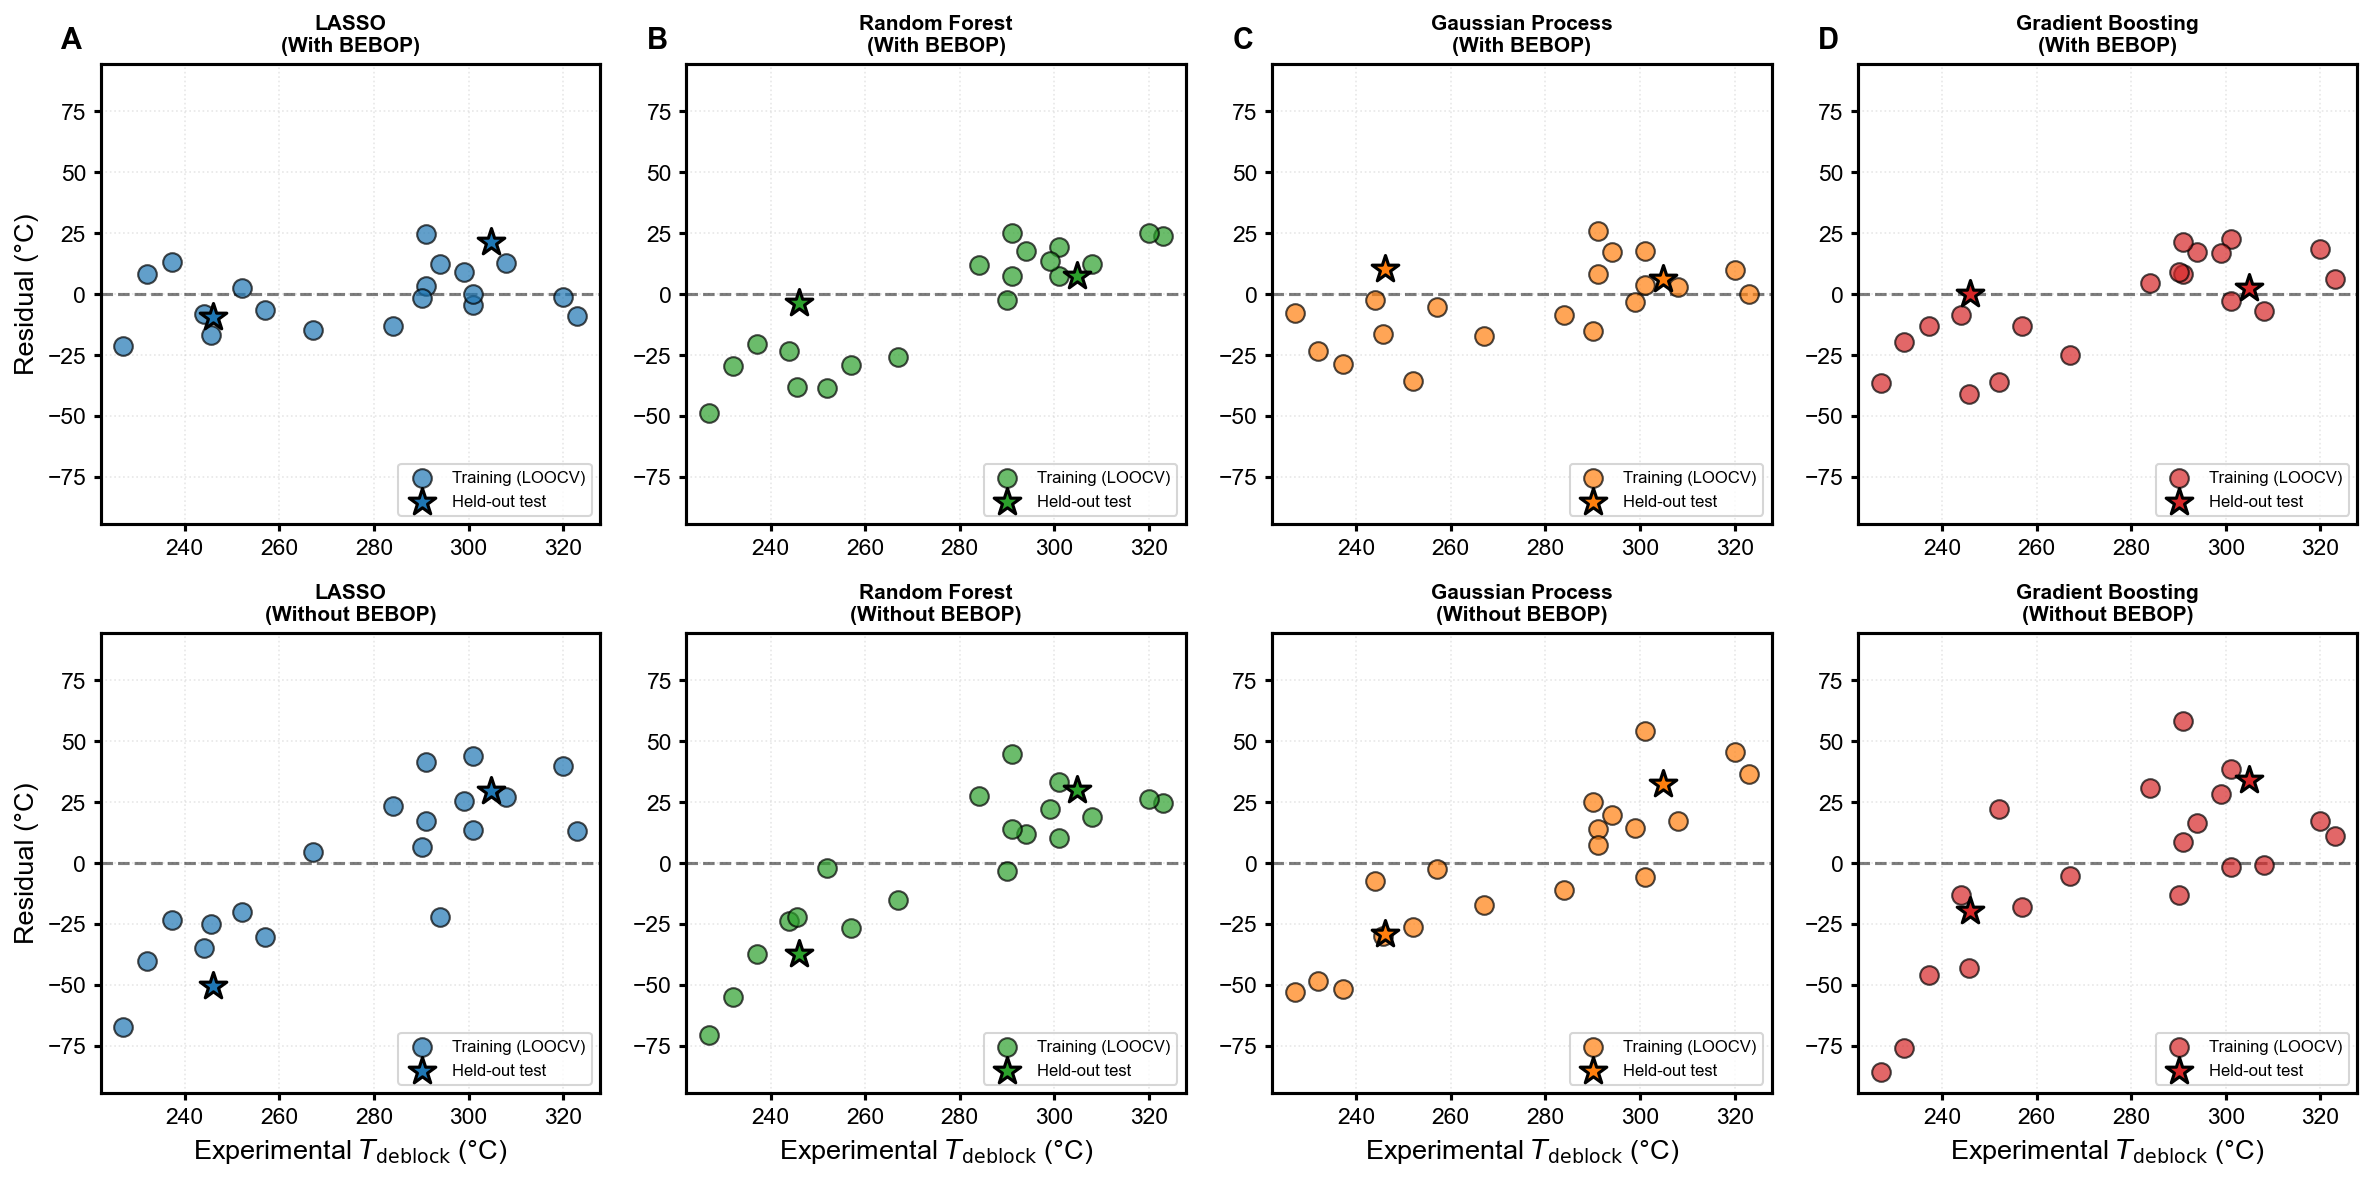


Figure saved as:
  - residual_comparison_all_models.png
  - residual_comparison_all_models.pdf

RESIDUAL STATISTICS

--- Training Set Residuals (LOOCV, n=19) ---



Model,Mean (w/ BEBOP),Mean (w/o BEBOP),Std (w/ BEBOP),Std (w/o BEBOP),Max |Residual| (w/ BEBOP),Max |Residual| (w/o BEBOP)
LASSO,-0.51,-0.42,11.70,30.93,24.61,67.11
Random Forest,-4.91,-1.19,24.39,30.61,48.80,70.35
Gaussian Process,-4.14,-1.02,15.85,30.71,35.56,53.97
Gradient Boosting,-4.08,-3.78,19.97,36.58,40.80,85.80



--- Interpretation ---
Mean ≈ 0: No systematic bias (model is unbiased)
Std ≈ RMSE: Errors are normally distributed
Max |residual| >> RMSE: Presence of outlier predictions

--- Test Set Residuals (Held-Out Compounds, n=2) ---



Model,Test Residuals (w/ BEBOP),Test Residuals (w/o BEBOP)
LASSO,"-9.5, +21.3","-50.4, +29.4"
Random Forest,"-3.6, +7.6","-37.4, +29.8"
Gaussian Process,"+10.1, +6.2","-29.0, +32.5"
Gradient Boosting,"-0.0, +2.5","-19.5, +34.2"


In [31]:
# =============================================================================
# Section 19: Residual Comparison Plots for All 21 Systems
# =============================================================================

# Combine training and test predictions for each model
# Training: LOOCV predictions (19 compounds)
# Test: Held-out predictions (2 compounds)

# Get test set predictions (if they exist from Section 18)
test_df_clean = test_df.dropna(subset=FEATURE_COLS).copy()

if len(test_df_clean) > 0:
    X_test = test_df_clean[FEATURE_COLS].to_numpy(dtype=float)
    X_test_scaled = scaler.transform(X_test)
    y_test_true = test_df_clean[TARGET_COL].values
    
    # Get test predictions for all models
    test_pred_lasso = lasso_final.predict(X_test_scaled)
    test_pred_rf = rf_model.predict(X_test_scaled)
    test_pred_gpr = gpr_model.predict(X_test_scaled)
    test_pred_gbr = gbr_model.predict(X_test_scaled)
    
    # For no-BEBOP models
    test_df_clean_nb = test_df.dropna(subset=FEATURE_COLS_NO_BEBOP).copy()
    X_test_nb = test_df_clean_nb[FEATURE_COLS_NO_BEBOP].to_numpy(dtype=float)
    X_test_nb_scaled = scaler_no_bebop.transform(X_test_nb)
    y_test_true_nb = test_df_clean_nb[TARGET_COL].values
    
    test_pred_lasso_nb = lasso_final_no_bebop.predict(X_test_nb_scaled)
    test_pred_rf_nb = rf_model_nb.predict(X_test_nb_scaled)
    test_pred_gpr_nb = gpr_model_nb.predict(X_test_nb_scaled)
    test_pred_gbr_nb = gbr_model_nb.predict(X_test_nb_scaled)
else:
    y_test_true = np.array([])
    test_pred_lasso = test_pred_rf = test_pred_gpr = test_pred_gbr = np.array([])
    test_pred_lasso_nb = test_pred_rf_nb = test_pred_gpr_nb = test_pred_gbr_nb = np.array([])

# Calculate residuals for all systems
# WITH BEBOP
residuals_train_lasso = y_train - y_pred_lasso
residuals_train_rf = y_train - y_pred_rf
residuals_train_gpr = y_train - y_pred_gpr
residuals_train_gbr = y_train - y_pred_gbr

residuals_test_lasso = y_test_true - test_pred_lasso if len(y_test_true) > 0 else np.array([])
residuals_test_rf = y_test_true - test_pred_rf if len(y_test_true) > 0 else np.array([])
residuals_test_gpr = y_test_true - test_pred_gpr if len(y_test_true) > 0 else np.array([])
residuals_test_gbr = y_test_true - test_pred_gbr if len(y_test_true) > 0 else np.array([])

# WITHOUT BEBOP
residuals_train_lasso_nb = y_train_no_bebop - y_pred_lasso_no_bebop
residuals_train_rf_nb = y_train_no_bebop - y_pred_rf_nb
residuals_train_gpr_nb = y_train_no_bebop - y_pred_gpr_nb
residuals_train_gbr_nb = y_train_no_bebop - y_pred_gbr_nb

residuals_test_lasso_nb = y_test_true_nb - test_pred_lasso_nb if len(test_df_clean_nb) > 0 else np.array([])
residuals_test_rf_nb = y_test_true_nb - test_pred_rf_nb if len(test_df_clean_nb) > 0 else np.array([])
residuals_test_gpr_nb = y_test_true_nb - test_pred_gpr_nb if len(test_df_clean_nb) > 0 else np.array([])
residuals_test_gbr_nb = y_test_true_nb - test_pred_gbr_nb if len(test_df_clean_nb) > 0 else np.array([])

# Calculate global axis limits for consistent scales across all subplots
# Collect all experimental values (same for all models)
all_experimental = y_train.copy()
if len(y_test_true) > 0:
    all_experimental = np.concatenate([all_experimental, y_test_true])

# Collect all residuals
all_residuals_with = np.concatenate([residuals_train_lasso, residuals_train_rf, residuals_train_gpr, residuals_train_gbr])
all_residuals_without = np.concatenate([residuals_train_lasso_nb, residuals_train_rf_nb, residuals_train_gpr_nb, residuals_train_gbr_nb])

if len(residuals_test_lasso) > 0:
    all_residuals_with = np.concatenate([all_residuals_with, residuals_test_lasso, residuals_test_rf, residuals_test_gpr, residuals_test_gbr])
if len(residuals_test_lasso_nb) > 0:
    all_residuals_without = np.concatenate([all_residuals_without, residuals_test_lasso_nb, residuals_test_rf_nb, residuals_test_gpr_nb, residuals_test_gbr_nb])

# Calculate global limits
x_min_global = all_experimental.min()
x_max_global = all_experimental.max()
x_range = x_max_global - x_min_global
x_lim = [x_min_global - 0.05 * x_range, x_max_global + 0.05 * x_range]

y_max_global = max(abs(all_residuals_with).max(), abs(all_residuals_without).max())
y_lim = [-y_max_global * 1.1, y_max_global * 1.1]

# Create 2x4 subplot matrix (2 rows, 4 columns)
# Row 1: WITH BEBOP (LASSO, RF, GPR, GBR)
# Row 2: WITHOUT BEBOP (LASSO, RF, GPR, GBR)
fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=150)

# Model names, residuals, and predicted values
models_with_bebop = [
    ('LASSO', residuals_train_lasso, residuals_test_lasso, y_pred_lasso, test_pred_lasso, '#1f77b4'),
    ('Random Forest', residuals_train_rf, residuals_test_rf, y_pred_rf, test_pred_rf, '#2ca02c'),
    ('Gaussian Process', residuals_train_gpr, residuals_test_gpr, y_pred_gpr, test_pred_gpr, '#ff7f0e'),
    ('Gradient Boosting', residuals_train_gbr, residuals_test_gbr, y_pred_gbr, test_pred_gbr, '#d62728')
]

models_without_bebop = [
    ('LASSO', residuals_train_lasso_nb, residuals_test_lasso_nb, y_pred_lasso_no_bebop, test_pred_lasso_nb, '#1f77b4'),
    ('Random Forest', residuals_train_rf_nb, residuals_test_rf_nb, y_pred_rf_nb, test_pred_rf_nb, '#2ca02c'),
    ('Gaussian Process', residuals_train_gpr_nb, residuals_test_gpr_nb, y_pred_gpr_nb, test_pred_gpr_nb, '#ff7f0e'),
    ('Gradient Boosting', residuals_train_gbr_nb, residuals_test_gbr_nb, y_pred_gbr_nb, test_pred_gbr_nb, '#d62728')
]

# Panel labels - ONLY A, B, C, D for top row
panel_labels = ['A', 'B', 'C', 'D']

# ROW 1: WITH BEBOP (top row)
for col_idx, (model_name, res_train, res_test, pred_train, pred_test, color) in enumerate(models_with_bebop):
    ax = axes[0, col_idx]
    
    # Training residuals vs predicted values (circles)
    ax.scatter(y_train, res_train, c=color, edgecolor='black',
               s=80, alpha=0.7, linewidths=1, label='Training (LOOCV)', zorder=3)
    
    # Test residuals vs predicted values (stars)
    if len(res_test) > 0 and len(pred_test) > 0:
        ax.scatter(y_test_true, res_test, c=color, marker='*',
                   edgecolor='black', s=180, linewidths=1.5,
                   label='Held-out test', zorder=4)
    
    # Zero line (perfect prediction)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, zorder=2)
    
    # Formatting
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Title
    ax.set_title(f'{model_name}\n(With BEBOP)', fontsize=10, fontweight='bold')
    
    # Y-label only on leftmost column
    if col_idx == 0:
        ax.set_ylabel('Residual (°C)')
    
    # X-axis labels on all panels
    
    # Panel label - ONLY for top row (A, B, C, D)
    ax.text(-0.08, 1.02, panel_labels[col_idx], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='bottom', ha='left')
    
    # Legend in ALL panels
    
    # Set consistent axis limits across all subplots
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    

# ROW 2: WITHOUT BEBOP (bottom row) - NO PANEL LABELS
for col_idx, (model_name, res_train_nb, res_test_nb, pred_train_nb, pred_test_nb, color) in enumerate(models_without_bebop):
    ax = axes[1, col_idx]
    
    # Training residuals vs predicted values (circles)
    ax.scatter(y_train_no_bebop, res_train_nb, c=color, edgecolor='black',
               s=80, alpha=0.7, linewidths=1, label='Training (LOOCV)', zorder=3)
    
    # Test residuals vs predicted values (stars)
    if len(res_test_nb) > 0 and len(pred_test_nb) > 0:
        ax.scatter(y_test_true_nb, res_test_nb, c=color, marker='*',
                   edgecolor='black', s=180, linewidths=1.5,
                   label='Held-out test', zorder=4)
    
    # Zero line
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, zorder=2)
    
    # Formatting
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Title
    ax.set_title(f'{model_name}\n(Without BEBOP)', fontsize=10, fontweight='bold')
    
    # Y-label only on leftmost column
    if col_idx == 0:
        ax.set_ylabel('Residual (°C)')
    
    # X-label on all bottom panels - now shows predicted values
    ax.set_xlabel(r'Experimental $T_{\mathrm{deblock}}$ (°C)')
    
    # NO panel label for bottom row
    
    # Legend in ALL panels
    
    # Set consistent axis limits across all subplots
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    


plt.tight_layout()

# Save figure in both formats
plt.savefig('residual_comparison_all_models.png', dpi=300, bbox_inches='tight')
plt.savefig('residual_comparison_all_models.pdf', dpi=300, bbox_inches='tight')

plt.show()

print("\nFigure saved as:")
print("  - residual_comparison_all_models.png")
print("  - residual_comparison_all_models.pdf")

# ===== STATISTICAL SUMMARY OF RESIDUALS =====

print("\n" + "=" * 90)
print("RESIDUAL STATISTICS")
print("=" * 90)

residual_stats = pd.DataFrame({
    'Model': ['LASSO', 'Random Forest', 'Gaussian Process', 'Gradient Boosting'],
    'Mean (w/ BEBOP)': [
        np.mean(residuals_train_lasso),
        np.mean(residuals_train_rf),
        np.mean(residuals_train_gpr),
        np.mean(residuals_train_gbr)
    ],
    'Mean (w/o BEBOP)': [
        np.mean(residuals_train_lasso_nb),
        np.mean(residuals_train_rf_nb),
        np.mean(residuals_train_gpr_nb),
        np.mean(residuals_train_gbr_nb)
    ],
    'Std (w/ BEBOP)': [
        np.std(residuals_train_lasso),
        np.std(residuals_train_rf),
        np.std(residuals_train_gpr),
        np.std(residuals_train_gbr)
    ],
    'Std (w/o BEBOP)': [
        np.std(residuals_train_lasso_nb),
        np.std(residuals_train_rf_nb),
        np.std(residuals_train_gpr_nb),
        np.std(residuals_train_gbr_nb)
    ],
    'Max |Residual| (w/ BEBOP)': [
        np.max(np.abs(residuals_train_lasso)),
        np.max(np.abs(residuals_train_rf)),
        np.max(np.abs(residuals_train_gpr)),
        np.max(np.abs(residuals_train_gbr))
    ],
    'Max |Residual| (w/o BEBOP)': [
        np.max(np.abs(residuals_train_lasso_nb)),
        np.max(np.abs(residuals_train_rf_nb)),
        np.max(np.abs(residuals_train_gpr_nb)),
        np.max(np.abs(residuals_train_gbr_nb))
    ]
})

print("\n--- Training Set Residuals (LOOCV, n=19) ---\n")
display(residual_stats.style.format({
    'Mean (w/ BEBOP)': '{:+.2f}',
    'Mean (w/o BEBOP)': '{:+.2f}',
    'Std (w/ BEBOP)': '{:.2f}',
    'Std (w/o BEBOP)': '{:.2f}',
    'Max |Residual| (w/ BEBOP)': '{:.2f}',
    'Max |Residual| (w/o BEBOP)': '{:.2f}'
}).hide(axis='index'))

print("\n--- Interpretation ---")
print("Mean ≈ 0: No systematic bias (model is unbiased)")
print("Std ≈ RMSE: Errors are normally distributed")
print("Max |residual| >> RMSE: Presence of outlier predictions")

if len(y_test_true) > 0:
    print("\n--- Test Set Residuals (Held-Out Compounds, n=2) ---\n")
    test_residual_df = pd.DataFrame({
        'Model': ['LASSO', 'Random Forest', 'Gaussian Process', 'Gradient Boosting'],
        'Test Residuals (w/ BEBOP)': [
            ', '.join([f'{r:+.1f}' for r in residuals_test_lasso]),
            ', '.join([f'{r:+.1f}' for r in residuals_test_rf]),
            ', '.join([f'{r:+.1f}' for r in residuals_test_gpr]),
            ', '.join([f'{r:+.1f}' for r in residuals_test_gbr])
        ],
        'Test Residuals (w/o BEBOP)': [
            ', '.join([f'{r:+.1f}' for r in residuals_test_lasso_nb]),
            ', '.join([f'{r:+.1f}' for r in residuals_test_rf_nb]),
            ', '.join([f'{r:+.1f}' for r in residuals_test_gpr_nb]),
            ', '.join([f'{r:+.1f}' for r in residuals_test_gbr_nb])
        ]
    })
    display(test_residual_df.style.hide(axis='index'))

print("=" * 90)


## 20. Paired *t*-Tests <a id="part2-12"></a>

Paired *t*-tests on per-compound squared LOOCV residuals ($\alpha = 0.05$, two-sided):

**(A)** LASSO vs. RF/GPR/GBR with BEBOP — do nonlinear models improve over LASSO?
**(B)** LASSO vs. RF/GPR/GBR without BEBOP — same comparison, non-BEBOP features only.
**(C)** BEBOP effect — for each model, does adding BEBOP descriptors reduce prediction error?

In [32]:
# =============================================================================
# Section 20: Paired t-tests on per-compound squared LOOCV residuals
# H₀: mean squared error is equal for the two models being compared
# =============================================================================
from scipy import stats

print("=" * 60)
print("STATISTICAL COMPARISON — Paired t-Tests (Squared Residuals)")
print("=" * 60)

# Per-compound squared residuals from LOOCV (WITH BEBOP)
sq_resid_bebop = {
    'LASSO': (y_train - y_pred_lasso) ** 2,
    'RF':    (y_train - y_pred_rf) ** 2,
    'GPR':   (y_train - y_pred_gpr) ** 2,
    'GBR':   (y_train - y_pred_gbr) ** 2
}

# Per-compound squared residuals from LOOCV (WITHOUT BEBOP)
sq_resid_no_bebop = {
    'LASSO': (y_train_no_bebop - y_pred_lasso_no_bebop) ** 2,
    'RF':    (y_train_no_bebop - y_pred_rf_nb) ** 2,
    'GPR':   (y_train_no_bebop - y_pred_gpr_nb) ** 2,
    'GBR':   (y_train_no_bebop - y_pred_gbr_nb) ** 2
}

rows = []

# (A) LASSO vs each other model — with BEBOP descriptors
print("\n--- LASSO vs Other Models (With BEBOP) ---")
for model in ['RF', 'GPR', 'GBR']:
    t_stat, p_val = stats.ttest_rel(sq_resid_bebop['LASSO'], sq_resid_bebop[model])
    sig = p_val < 0.05
    rmse_lasso = np.sqrt(sq_resid_bebop['LASSO'].mean())
    rmse_other = np.sqrt(sq_resid_bebop[model].mean())
    print(f"  LASSO ({rmse_lasso:.2f}) vs {model:4s} ({rmse_other:.2f}):  "
          f"t = {t_stat:+.4f},  p = {p_val:.4e}  "
          f"{'→ Significant' if sig else '→ Not significant'}")
    rows.append({
        'Comparison': f'LASSO vs {model} (with BEBOP)',
        'RMSE₁ (°C)': rmse_lasso,
        'RMSE₂ (°C)': rmse_other,
        't-statistic': t_stat,
        'p-value': p_val,
        'Significant (α=0.05)': sig
    })

# (B) LASSO vs each other model — without BEBOP descriptors
print("\n--- LASSO vs Other Models (Without BEBOP) ---")
for model in ['RF', 'GPR', 'GBR']:
    t_stat, p_val = stats.ttest_rel(sq_resid_no_bebop['LASSO'], sq_resid_no_bebop[model])
    sig = p_val < 0.05
    rmse_lasso = np.sqrt(sq_resid_no_bebop['LASSO'].mean())
    rmse_other = np.sqrt(sq_resid_no_bebop[model].mean())
    print(f"  LASSO ({rmse_lasso:.2f}) vs {model:4s} ({rmse_other:.2f}):  "
          f"t = {t_stat:+.4f},  p = {p_val:.4e}  "
          f"{'→ Significant' if sig else '→ Not significant'}")
    rows.append({
        'Comparison': f'LASSO vs {model} (without BEBOP)',
        'RMSE₁ (°C)': rmse_lasso,
        'RMSE₂ (°C)': rmse_other,
        't-statistic': t_stat,
        'p-value': p_val,
        'Significant (α=0.05)': sig
    })

# (C) BEBOP effect: does adding BEBOP descriptors improve each model?
print("\n--- BEBOP Effect (With vs Without, same model) ---")
for model in ['LASSO', 'RF', 'GPR', 'GBR']:
    t_stat, p_val = stats.ttest_rel(sq_resid_bebop[model], sq_resid_no_bebop[model])
    sig = p_val < 0.05
    rmse_with = np.sqrt(sq_resid_bebop[model].mean())
    rmse_without = np.sqrt(sq_resid_no_bebop[model].mean())
    print(f"  {model:5s}: w/ BEBOP ({rmse_with:.2f}) vs w/o ({rmse_without:.2f}):  "
          f"t = {t_stat:+.4f},  p = {p_val:.4e}  "
          f"{'→ Significant' if sig else '→ Not significant'}")
    rows.append({
        'Comparison': f'{model}: BEBOP vs no BEBOP',
        'RMSE₁ (°C)': rmse_with,
        'RMSE₂ (°C)': rmse_without,
        't-statistic': t_stat,
        'p-value': p_val,
        'Significant (α=0.05)': sig
    })

# Consolidated summary table
print("\n--- Summary Table ---")
summary_df = pd.DataFrame(rows)
display(summary_df.style.format({
    'RMSE₁ (°C)': '{:.2f}',
    'RMSE₂ (°C)': '{:.2f}',
    't-statistic': '{:+.4f}',
    'p-value': '{:.4e}'
}).hide(axis='index'))

STATISTICAL COMPARISON — Paired t-Tests (Squared Residuals)

--- LASSO vs Other Models (With BEBOP) ---
  LASSO (11.71) vs RF   (24.88):  t = -3.8255,  p = 1.2390e-03  → Significant
  LASSO (11.71) vs GPR  (16.38):  t = -1.6001,  p = 1.2698e-01  → Not significant
  LASSO (11.71) vs GBR  (20.38):  t = -2.6945,  p = 1.4823e-02  → Significant

--- LASSO vs Other Models (Without BEBOP) ---
  LASSO (30.94) vs RF   (30.63):  t = +0.1448,  p = 8.8645e-01  → Not significant
  LASSO (30.94) vs GPR  (30.73):  t = +0.0594,  p = 9.5330e-01  → Not significant
  LASSO (30.94) vs GBR  (36.78):  t = -1.2647,  p = 2.2210e-01  → Not significant

--- BEBOP Effect (With vs Without, same model) ---
  LASSO: w/ BEBOP (11.71) vs w/o (30.94):  t = -3.6830,  p = 1.7018e-03  → Significant
  RF   : w/ BEBOP (24.88) vs w/o (30.63):  t = -1.4483,  p = 1.6473e-01  → Not significant
  GPR  : w/ BEBOP (16.38) vs w/o (30.73):  t = -2.8722,  p = 1.0135e-02  → Significant
  GBR  : w/ BEBOP (20.38) vs w/o (36.78):  t = -

Comparison,RMSE₁ (°C),RMSE₂ (°C),t-statistic,p-value,Significant (α=0.05)
LASSO vs RF (with BEBOP),11.71,24.88,-3.8255,1.2390e-03,True
LASSO vs GPR (with BEBOP),11.71,16.38,-1.6001,1.2698e-01,False
LASSO vs GBR (with BEBOP),11.71,20.38,-2.6945,1.4823e-02,True
LASSO vs RF (without BEBOP),30.94,30.63,+0.1448,8.8645e-01,False
LASSO vs GPR (without BEBOP),30.94,30.73,+0.0594,9.5330e-01,False
LASSO vs GBR (without BEBOP),30.94,36.78,-1.2647,2.2210e-01,False
LASSO: BEBOP vs no BEBOP,11.71,30.94,-3.6830,1.7018e-03,True
RF: BEBOP vs no BEBOP,24.88,30.63,-1.4483,1.6473e-01,False
GPR: BEBOP vs no BEBOP,16.38,30.73,-2.8722,1.0135e-02,True
GBR: BEBOP vs no BEBOP,20.38,36.78,-2.1620,4.4330e-02,True


## 21. Bootstrap Confidence Intervals on ΔRMSE <a id="part2-13"></a>

Complementary to the paired $t$-test, nonparametric bootstrap confidence intervals on $\Delta\mathrm{RMSE}$ quantify the magnitude and uncertainty of pairwise performance differences without assuming independence of LOOCV folds.

Given LOOCV residuals $\{r_i^A\}$ and $\{r_i^B\}$, each bootstrap replicate resamples compound indices with replacement and computes $\Delta\mathrm{RMSE}^{(b)} = \mathrm{RMSE}_A^{(b)} - \mathrm{RMSE}_B^{(b)}$. The 95% CI is taken from the 2.5th and 97.5th percentiles over $B = 10{,}000$ replicates (seed = 42). If the CI excludes zero, the difference is statistically meaningful.

---

In [33]:
# =============================================================================
# Section 21: Bootstrap Confidence Intervals on Pairwise ΔRMSE
# B = 10,000 replicates, 95% percentile CI
# =============================================================================

print("=" * 70)
print("BOOTSTRAP CONFIDENCE INTERVALS ON ΔRMSE")
print("=" * 70)


def bootstrap_delta_rmse(resid_A, resid_B, n_boot=10000, seed=42, ci=95):
    """
    Bootstrap confidence interval for RMSE_A - RMSE_B.

    Resamples compound indices with replacement and computes
    ΔRMSE = RMSE_A - RMSE_B for each replicate. Returns the mean
    difference and percentile confidence interval.

    Parameters
    ----------
    resid_A, resid_B : array-like, shape (n,)
        Per-compound residuals (y_true - y_pred) for models A and B
    n_boot : int
        Number of bootstrap replicates
    seed : int
        Random seed for reproducibility
    ci : float
        Confidence level (default: 95%)

    Returns
    -------
    mean_delta : float
        Mean ΔRMSE across bootstrap replicates
    ci_lo, ci_hi : float
        Lower and upper bounds of the confidence interval
    deltas : ndarray
        Full bootstrap distribution (for optional plotting)
    """
    rng = np.random.RandomState(seed)
    n = len(resid_A)
    deltas = np.zeros(n_boot)
    alpha = (100 - ci) / 2

    for b in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        rmse_A = np.sqrt(np.mean(resid_A[idx] ** 2))
        rmse_B = np.sqrt(np.mean(resid_B[idx] ** 2))
        deltas[b] = rmse_A - rmse_B

    ci_lo = np.percentile(deltas, alpha)
    ci_hi = np.percentile(deltas, 100 - alpha)
    return np.mean(deltas), ci_lo, ci_hi, deltas


# LOOCV residuals (WITH BEBOP)
resid_bebop = {
    'LASSO': y_train - y_pred_lasso,
    'RF':    y_train - y_pred_rf,
    'GPR':   y_train - y_pred_gpr,
    'GBR':   y_train - y_pred_gbr
}

# LOOCV residuals (WITHOUT BEBOP)
resid_no_bebop = {
    'LASSO': y_train_no_bebop - y_pred_lasso_no_bebop,
    'RF':    y_train_no_bebop - y_pred_rf_nb,
    'GPR':   y_train_no_bebop - y_pred_gpr_nb,
    'GBR':   y_train_no_bebop - y_pred_gbr_nb
}

boot_rows = []
all_deltas = {}

# (A) LASSO vs other models — with BEBOP
print("\n--- LASSO vs Other Models (With BEBOP) ---")
for model in ['RF', 'GPR', 'GBR']:
    mean_d, lo, hi, deltas = bootstrap_delta_rmse(
        resid_bebop['LASSO'], resid_bebop[model])
    excludes_zero = (lo > 0) or (hi < 0)
    label = f'LASSO vs {model} (with BEBOP)'
    all_deltas[label] = deltas
    print(f"  LASSO vs {model:4s}:  ΔRMSE = {mean_d:+.2f} °C  "
          f"95% CI [{lo:+.2f}, {hi:+.2f}]  "
          f"{'*' if excludes_zero else ''}")
    boot_rows.append({
        'Comparison': label,
        'ΔRMSE (°C)': mean_d,
        '95% CI lower': lo,
        '95% CI upper': hi,
        'Excludes zero': excludes_zero
    })

# (B) LASSO vs other models — without BEBOP
print("\n--- LASSO vs Other Models (Without BEBOP) ---")
for model in ['RF', 'GPR', 'GBR']:
    mean_d, lo, hi, deltas = bootstrap_delta_rmse(
        resid_no_bebop['LASSO'], resid_no_bebop[model])
    excludes_zero = (lo > 0) or (hi < 0)
    label = f'LASSO vs {model} (without BEBOP)'
    all_deltas[label] = deltas
    print(f"  LASSO vs {model:4s}:  ΔRMSE = {mean_d:+.2f} °C  "
          f"95% CI [{lo:+.2f}, {hi:+.2f}]  "
          f"{'*' if excludes_zero else ''}")
    boot_rows.append({
        'Comparison': label,
        'ΔRMSE (°C)': mean_d,
        '95% CI lower': lo,
        '95% CI upper': hi,
        'Excludes zero': excludes_zero
    })

# (C) BEBOP effect — same model, with vs without
print("\n--- BEBOP Effect (With vs Without, same model) ---")
for model in ['LASSO', 'RF', 'GPR', 'GBR']:
    mean_d, lo, hi, deltas = bootstrap_delta_rmse(
        resid_bebop[model], resid_no_bebop[model])
    excludes_zero = (lo > 0) or (hi < 0)
    label = f'{model}: BEBOP vs no BEBOP'
    all_deltas[label] = deltas
    print(f"  {model:5s}:  ΔRMSE = {mean_d:+.2f} °C  "
          f"95% CI [{lo:+.2f}, {hi:+.2f}]  "
          f"{'*' if excludes_zero else ''}")
    boot_rows.append({
        'Comparison': label,
        'ΔRMSE (°C)': mean_d,
        '95% CI lower': lo,
        '95% CI upper': hi,
        'Excludes zero': excludes_zero
    })

# Summary table
print("\n" + "=" * 70)
print("BOOTSTRAP SUMMARY (10,000 replicates, 95% percentile CI)")
print("=" * 70)
print("* = CI excludes zero (statistically meaningful difference)\n")

boot_df = pd.DataFrame(boot_rows)
display(boot_df.style.format({
    'ΔRMSE (°C)': '{:+.2f}',
    '95% CI lower': '{:+.2f}',
    '95% CI upper': '{:+.2f}'
}).hide(axis='index'))

n_meaningful = sum(r['Excludes zero'] for r in boot_rows)
print(f"\nComparisons where CI excludes zero: {n_meaningful}/{len(boot_rows)}")

BOOTSTRAP CONFIDENCE INTERVALS ON ΔRMSE

--- LASSO vs Other Models (With BEBOP) ---
  LASSO vs RF  :  ΔRMSE = -13.17 °C  95% CI [-17.84, -8.39]  *
  LASSO vs GPR :  ΔRMSE = -4.56 °C  95% CI [-9.82, +0.51]  
  LASSO vs GBR :  ΔRMSE = -8.61 °C  95% CI [-13.52, -3.76]  *

--- LASSO vs Other Models (Without BEBOP) ---
  LASSO vs RF  :  ΔRMSE = +0.39 °C  95% CI [-3.59, +4.62]  
  LASSO vs GPR :  ΔRMSE = +0.27 °C  95% CI [-6.53, +7.08]  
  LASSO vs GBR :  ΔRMSE = -5.55 °C  95% CI [-13.04, +2.80]  

--- BEBOP Effect (With vs Without, same model) ---
  LASSO:  ΔRMSE = -19.16 °C  95% CI [-25.65, -12.79]  *
  RF   :  ΔRMSE = -5.61 °C  95% CI [-11.85, +1.56]  
  GPR  :  ΔRMSE = -14.33 °C  95% CI [-22.01, -5.95]  *
  GBR  :  ΔRMSE = -16.10 °C  95% CI [-26.78, -4.80]  *

BOOTSTRAP SUMMARY (10,000 replicates, 95% percentile CI)
* = CI excludes zero (statistically meaningful difference)



Comparison,ΔRMSE (°C),95% CI lower,95% CI upper,Excludes zero
LASSO vs RF (with BEBOP),-13.17,-17.84,-8.39,True
LASSO vs GPR (with BEBOP),-4.56,-9.82,+0.51,False
LASSO vs GBR (with BEBOP),-8.61,-13.52,-3.76,True
LASSO vs RF (without BEBOP),+0.39,-3.59,+4.62,False
LASSO vs GPR (without BEBOP),+0.27,-6.53,+7.08,False
LASSO vs GBR (without BEBOP),-5.55,-13.04,+2.80,False
LASSO: BEBOP vs no BEBOP,-19.16,-25.65,-12.79,True
RF: BEBOP vs no BEBOP,-5.61,-11.85,+1.56,False
GPR: BEBOP vs no BEBOP,-14.33,-22.01,-5.95,True
GBR: BEBOP vs no BEBOP,-16.10,-26.78,-4.80,True



Comparisons where CI excludes zero: 5/10


---

## Summary

**Part I:** Identified descriptors with strong correlations to $T_{\mathrm{deblock}}$ and characterized multicollinearity among BEBOP descriptors.

**Part II:** LASSO with BEBOP descriptors achieved the lowest LOOCV RMSE. The BEBOP effect was statistically meaningful for 3/4 models by bootstrap CI. AIC/BIC supported BEBOP inclusion for 3/4 (BIC) and 4/4 (AIC) models. All code and data available at [github.com/BLZ11/deblocking_temp](https://github.com/BLZ11/deblocking_temp).

---

*End of Supporting Information*